In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
import random
import umap
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, pairwise_distances
from sklearn.manifold import TSNE, trustworthiness

from IPython.display import display

from saxpy.paa import paa
from saxpy.alphabet import cuts_for_asize
from saxpy.sax import ts_to_string

from pyts.approximation import SymbolicAggregateApproximation

In [2]:
warnings.filterwarnings("ignore")

In [3]:
num_intervals = 96

In [4]:
target_building = (
    'UCD - University College Dublin > Belfield > Quinn and Moore School of Business > Electricity > Quinn School Electricity (Includes SSOL & Moore)',
    'UCD - University College Dublin > Belfield > Sutherland School of Law > Electricity > Sutherland School of Law Electricity',
    'UCD - University College Dublin > Residences > Roebuck > Electricity > Roebuck Apartments Total Electricity',
    'UCD - University College Dublin > Residences > Ashfield > Electricity > Ashfield Electricity Total (Import & Solar)',
    'UCD - University College Dublin > Belfield > Engineering > Engineering and Clinton Auditorium > Engineering and Materials Science'
)

In [5]:
right_skew = (
    'UCD - University College Dublin > Belfield > Quinn and Moore School of Business > Electricity > Quinn School Electricity (Includes SSOL & Moore)',
    'UCD - University College Dublin > Belfield > Sutherland School of Law > Electricity > Sutherland School of Law Electricity',
    'UCD - University College Dublin > Residences > Ashfield > Electricity > Ashfield Electricity Total (Import & Solar)',
    'UCD - University College Dublin > Belfield > Engineering > Engineering and Clinton Auditorium > Engineering and Materials Science'
)

left_skew = ()

bi_modal = (
    'UCD - University College Dublin > Residences > Roebuck > Electricity > Roebuck Apartments Total Electricity',
)

In [6]:
pl_df = pl.read_csv('unpivoted.csv') \
        .filter(pl.col('building_name').is_in(target_building))

In [7]:
# Extracting date features
pl_df = pl_df \
        .with_columns([
            (pl.col("Date") + " " + pl.col("time")).str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M").alias("Datetime")
        ]) \
        .with_columns([
            pl.col("Datetime").dt.date().alias("Date"),
            pl.col("Datetime").dt.hour().alias("Hour"),
            pl.col("Datetime").dt.strftime("%H:%M").alias("time"),
            pl.col("Datetime").dt.year().alias("Year"),
            pl.col("Datetime").dt.month().alias("Month"),
            pl.col("Datetime").dt.strftime("%A").alias("Weekday"),
            pl.col("Datetime").dt.strftime("%A").is_in(["Saturday", "Sunday"]).alias("is_weekend"),
            pl.when(pl.col("Datetime").dt.strftime("%A").is_in(["Saturday", "Sunday"])) \
            .then(pl.lit("Weekend")) \
            .otherwise(pl.lit("Weekday")) \
            .alias("day_type")
        ])

# Filling nulls for energy and creating intermediate columns
pl_df = pl_df.with_columns([
            pl.when(pl.col('Month').is_in([1, 2, 3, 4])).then(pl.lit('Spring')) \
            .when(pl.col('Month').is_in([5, 6, 7, 8])).then(pl.lit('Summer')) \
            .when(pl.col('Month').is_in([9, 10, 11, 12])).then(pl.lit('Autumn')) \
            .otherwise(pl.lit('Unknown')) \
            .alias('Term'),

            pl.when(pl.col("file_name").str.to_lowercase().str.contains("ashfield")).then(pl.lit("ashfield")) \
            .when(pl.col("file_name").str.to_lowercase().str.contains("engineering_engineering")).then(pl.lit("engineering_engineering")) \
            .otherwise(pl.col("building_name")) \
            .alias("building_v1"),

            pl.when(pl.col('energy_kw').is_not_null() & pl.col('energy_kw').is_not_nan()) \
            .then(pl.col('energy_kw')) \
            .otherwise(
                (pl.col("energy_kw") \
                .filter(pl.col('energy_kw').is_not_null() & pl.col('energy_kw').is_not_nan()) \
                .mean().over(["building_name", "Month", "Hour"])) / 4 \
            ).alias("energy_kw")
        ]) \
        .sort(['building_name', 'Datetime'])

In [8]:
year_lb = 2015
year_ub = 2024

In [9]:
pl_df = pl_df.with_columns([
  pl.when(pl.col('building_name').is_in(right_skew))
    .then(pl.col('energy_kw').sqrt())
    .when(pl.col('building_name').is_in(left_skew))
    .then(pl.col('energy_kw').pow(3))
    .when(pl.col('building_name').is_in(bi_modal))
    .then(pl.col('energy_kw').sqrt())
    .otherwise(pl.col('energy_kw'))
    .alias('energy_normal')
]) \
.with_columns([
    pl.when(pl.col('energy_normal').is_not_null() & pl.col('energy_normal').is_not_nan()) \
    .then(pl.col('energy_normal')) \
    .otherwise(
        (pl.col("energy_normal") \
        .filter(pl.col('energy_normal').is_not_null() & pl.col('energy_normal').is_not_nan()) \
        .mean().over(["building_name", "Month", "Hour"])) / 4 \
    ).alias("energy_normal") 
])

In [10]:
pl_df_filtered = pl_df.filter(pl.col("Year").is_between(year_lb, year_ub))

In [11]:
pd_df = pl_df_filtered.to_pandas()

In [12]:
print("\nDescriptive Statistics for Energy Data (Original & Normalized)")

# Use building_v1 instead of full path
stats_df = pl_df_filtered.to_pandas()

# --- Overall summary ---
overall_stats = stats_df[['energy_kw', 'energy_normal']].describe()
print("\n=== Overall Energy Stats ===")
print(overall_stats.round(3).to_string())

# --- Building-wise stats (short name) ---
building_stats = (
    stats_df.groupby('building_v1')[['energy_kw', 'energy_normal']]
    .agg(['mean', 'std', 'min', 'max'])
)
print("\n=== Building-wise Stats (Short Names) ===")
print(building_stats.round(3).to_string())

# --- Seasonal (Term-wise) stats ---
term_stats = (
    stats_df.groupby(['Term', 'building_v1'])[['energy_kw', 'energy_normal']]
    .agg(['mean', 'std', 'min', 'max'])
)
print("\n=== Term-wise Building Stats ===")
print(term_stats.round(3).to_string())


Descriptive Statistics for Energy Data (Original & Normalized)

=== Overall Energy Stats ===
         energy_kw  energy_normal
count  1692288.000    1692288.000
mean        18.551          4.054
std         12.592          1.455
min         -4.970          0.000
25%          8.802          2.967
50%         15.777          3.972
75%         25.145          5.014
max        135.100         11.623

=== Building-wise Stats (Short Names) ===
                                                                                                                                                 energy_kw                        energy_normal                    
                                                                                                                                                      mean     std   min      max          mean    std  min     max
building_v1                                                                                                                          

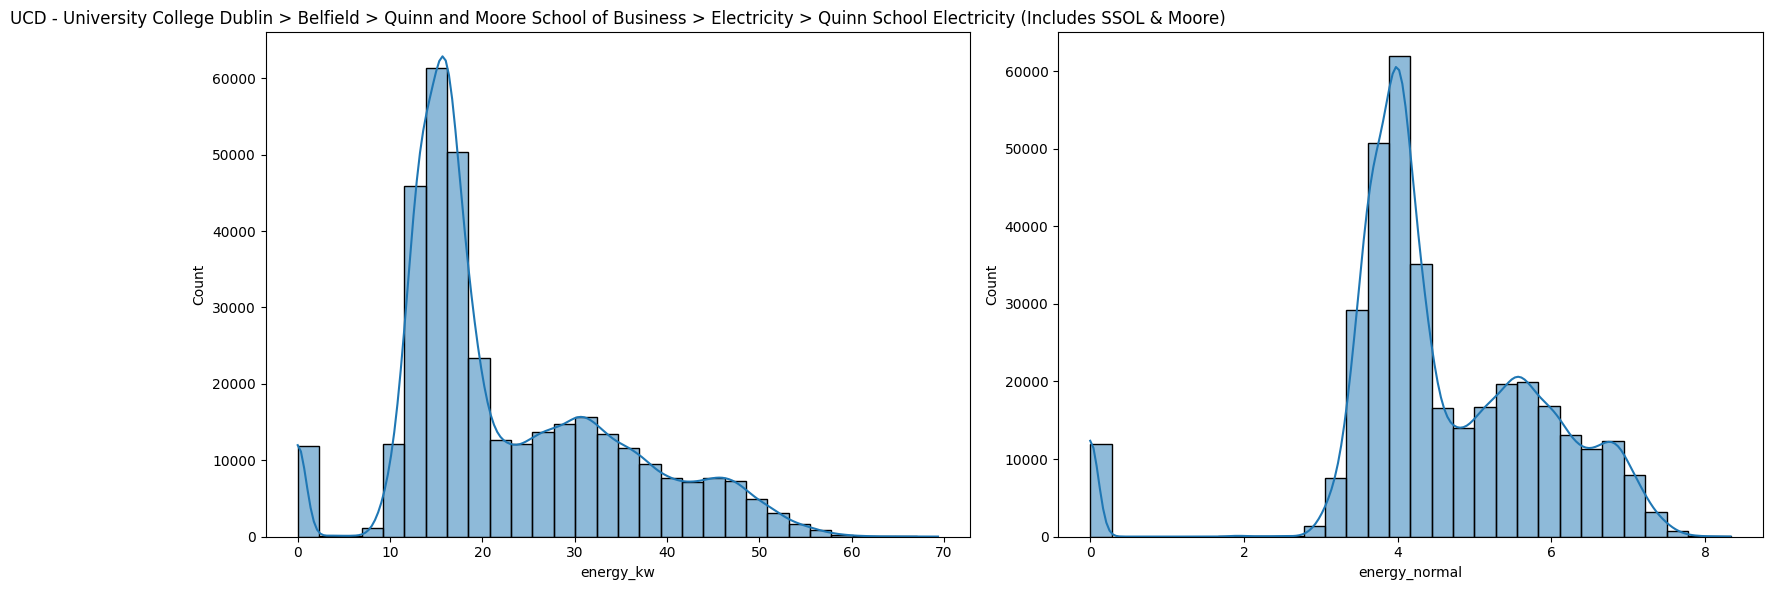

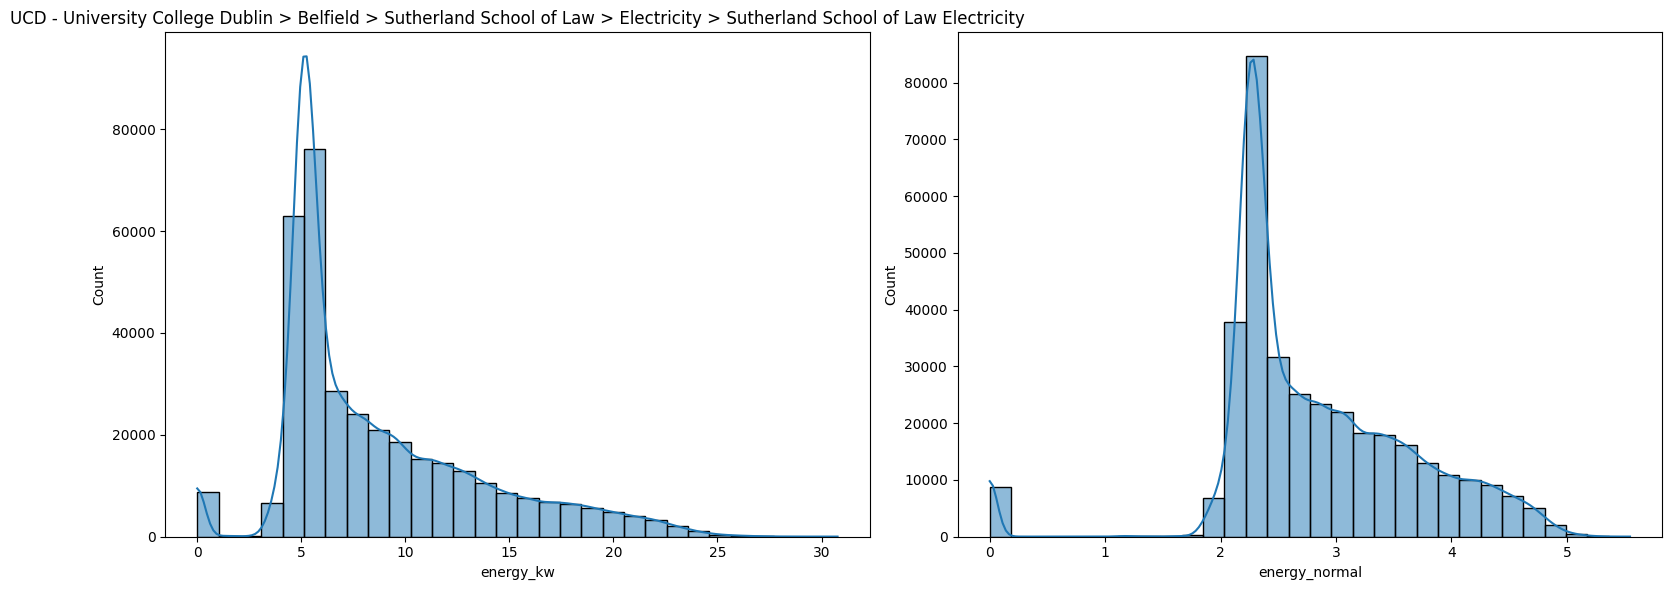

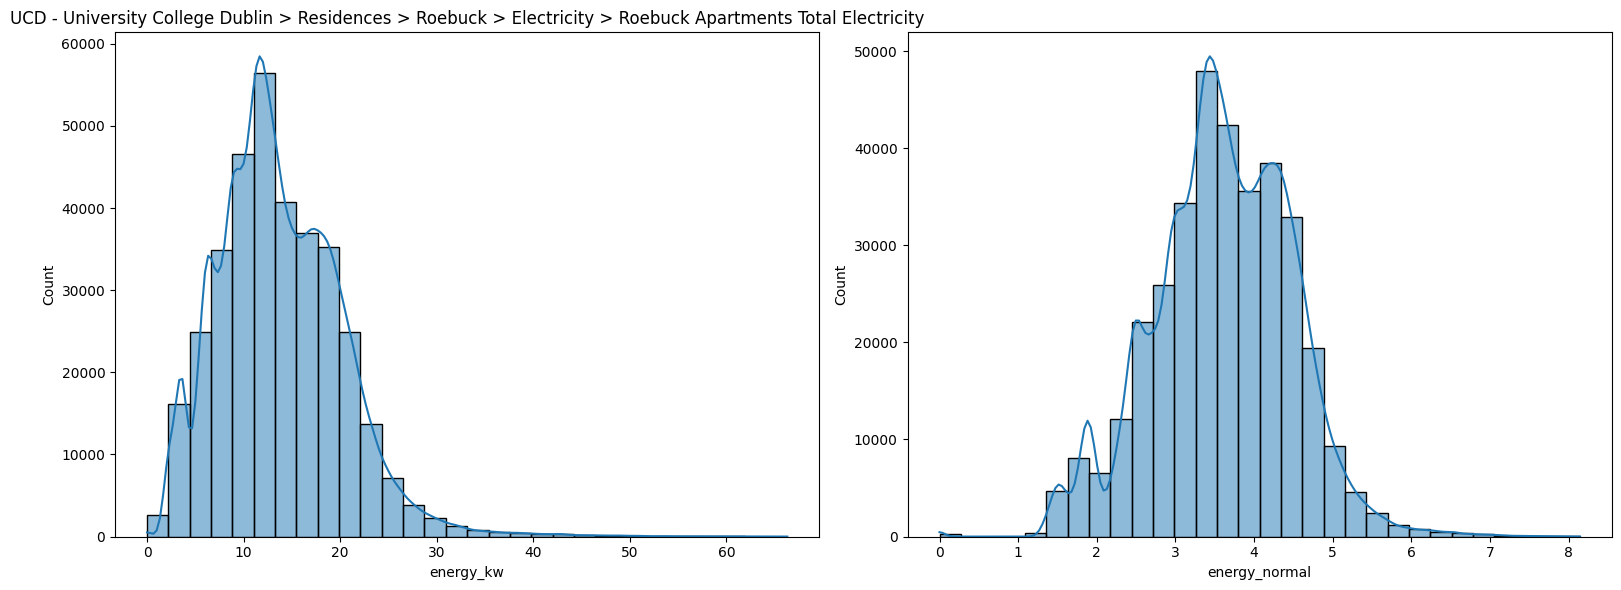

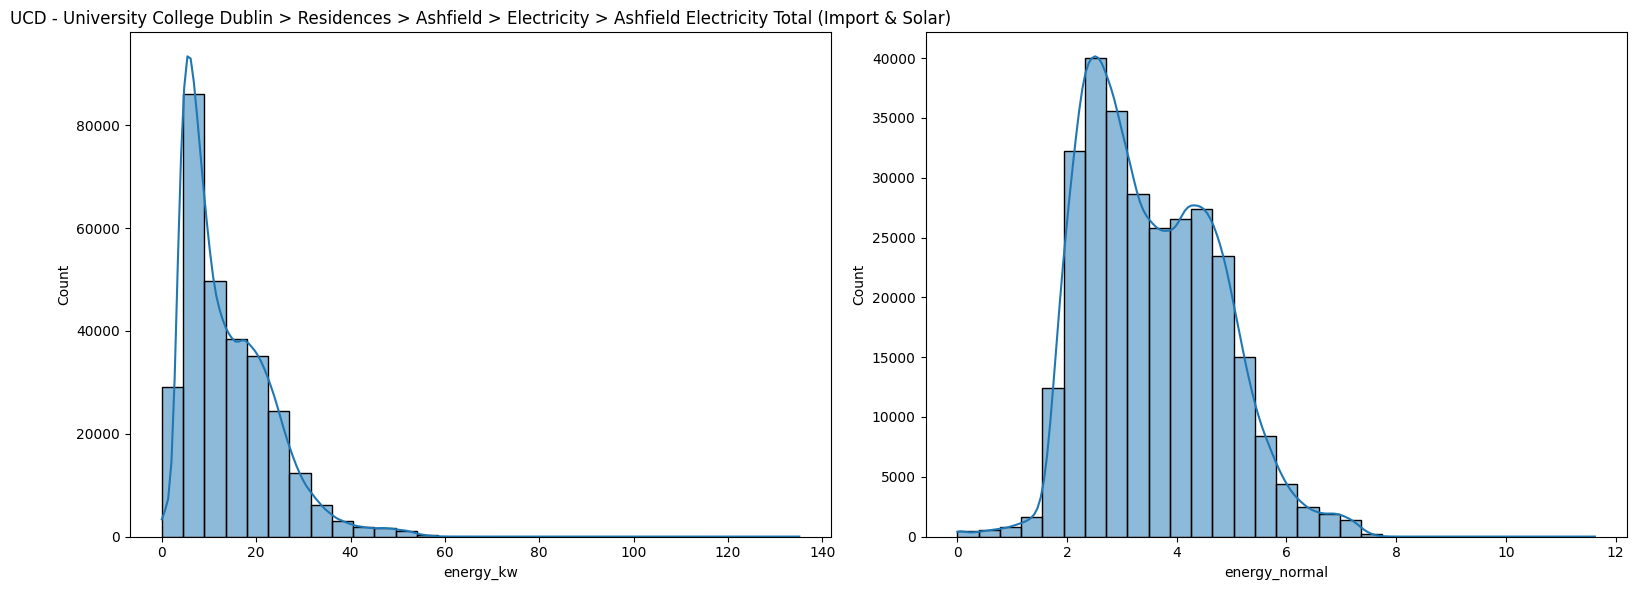

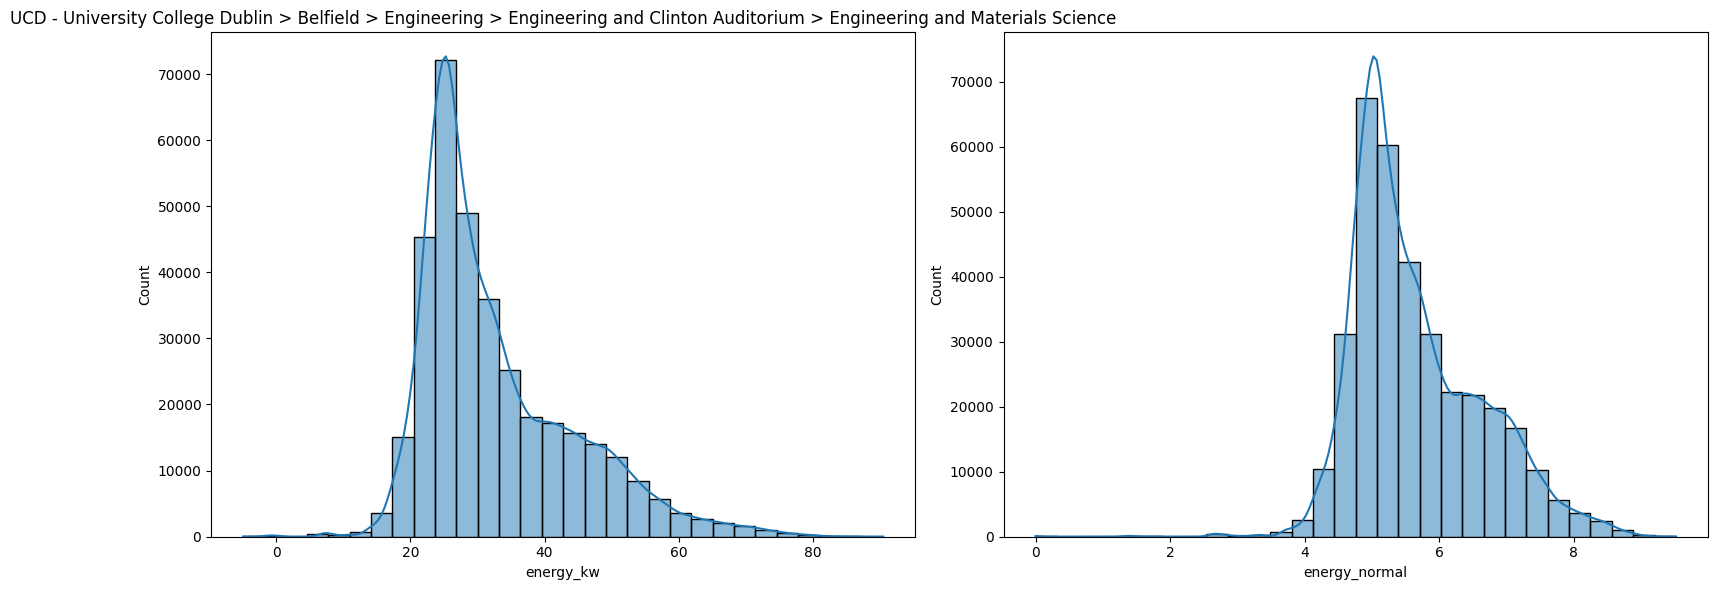

In [13]:
#Plot: Load Factor Distribution
for building in target_building:
    subset = pd_df[pd_df["building_name"] == building]
    if subset.empty:
        continue

    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # First histogram (left) - energy_kw
    sns.histplot(data=subset, x="energy_kw", kde=True, bins=30, ax=ax1)
    ax1.set_title(building)
    ax1.set_xlabel("energy_kw")
    
    # Second histogram (right) - energy_normal
    sns.histplot(data=subset, x="energy_normal", kde=True, bins=30, ax=ax2)
    ax2.set_xlabel("energy_normal")
    
    plt.tight_layout()
    plt.show()

In [14]:
details = (
    pl_df_filtered.select(
        pl.col('building_name'), 
        pl.col('Date'), 
        pl.col('Month'), 
        pl.col('Term'), 
        pl.col('Weekday')
    )
    .unique()
    .sort(['building_name', 'Date'])
)

buildings = details['building_name'].to_numpy()
dates = details['Date'].to_numpy()
months = details['Month'].to_numpy()
terms = details['Term'].to_numpy()
weekday = details['Weekday'].to_numpy()

In [15]:
# Normalize energy
energy = pl_df_filtered['energy_kw'].to_numpy()
energy_normal = pl_df_filtered['energy_normal'].to_numpy()

# Apply z-score normalization
norm_energy = (energy - energy.mean()) / energy.std()

norm_energy = norm_energy.reshape(norm_energy.shape[0] // num_intervals, num_intervals)
energy_normal = energy_normal.reshape(energy_normal.shape[0] // num_intervals, num_intervals)

In [16]:
class Transformations:
    def __init__(self, paa_segments=15, alphabet_size=9, k=8, n_components=2):
        self.paa_segments = paa_segments
        self.alphabet_size = alphabet_size
        self.n_components = n_components

    def apply_sax(self, norm_energy: np.ndarray, alphabet_size: int = None, paa_segments: int = None) -> np.ndarray:
        paa_segments = paa_segments if paa_segments else self.paa_segments
        alphabet_size = alphabet_size if alphabet_size else self.alphabet_size
        sax_output = None

        for r in norm_energy:
            paa_rep = paa(r, paa_segments)
            cuts = cuts_for_asize(alphabet_size)
            sax_string = ts_to_string(paa_rep, cuts)
            sax_numeric = np.array([ord(symbol) - ord('a') for symbol in sax_string])
            sax_output = sax_numeric if sax_output is None else np.vstack((sax_output, sax_numeric))

        return sax_output

    def apply_pca(self, sax_applied: np.ndarray, n_components: int = None) -> np.ndarray:
        n_components = n_components if n_components else self.n_components
        scaler = StandardScaler()
        energy_scaled = scaler.fit_transform(sax_applied)
        pca = PCA(n_components=n_components)
        return pca.fit_transform(energy_scaled)
    

    def evaluate_alphabet_sizes(self, norm_energy, alphabet_range=range(3, 10)):
        """
        Evaluate different alphabet sizes for SAX representation using
        information-theoretic and statistical measures without PCA or K-means.
        
        Args:
            norm_energy: 2D numpy array where each row is a time series
            alphabet_range: range of alphabet sizes to evaluate
        """
        results = []
        
        for alpha in alphabet_range:
            sax_output = self.apply_sax(norm_energy, alphabet_size=alpha)
            
            # Convert SAX symbols to numerical representation for analysis
            sax_numeric = self._sax_to_numeric(sax_output, alpha)
            
            # Method 1: Information Content Analysis
            entropy = self._calculate_entropy(sax_output)
            compression_ratio = self._calculate_compression_ratio(sax_output, norm_energy)
            
            # Method 2: Distribution Analysis
            symbol_distribution = self._analyze_symbol_distribution(sax_output, alpha)
            uniformity_score = self._calculate_uniformity(symbol_distribution)
            
            # Method 3: Reconstruction Error
            reconstruction_error = self._calculate_reconstruction_error(sax_output, norm_energy, alpha)
            
            # Method 4: Pattern Complexity
            pattern_complexity = self._calculate_pattern_complexity(sax_output)
            
            # Method 5: Information Loss Measure
            info_loss = self._calculate_information_loss(norm_energy, sax_numeric)
            
            # Method 6: Discriminative Power
            discriminative_power = self._calculate_discriminative_power(sax_output)
            
            results.append({
                'alphabet_size': alpha,
                'paa_segments': self.paa_segments,
                'entropy': entropy,
                'compression_ratio': compression_ratio,
                'uniformity_score': uniformity_score,
                'reconstruction_error': reconstruction_error,
                'pattern_complexity': pattern_complexity,
                'information_loss': info_loss,
                'discriminative_power': discriminative_power,
                'composite_score': self._calculate_composite_score(
                    entropy, compression_ratio, uniformity_score, 
                    reconstruction_error, pattern_complexity, info_loss, discriminative_power
                )
            })
        
        return pd.DataFrame(results)

    def _sax_to_numeric(self, sax_output, alphabet_size):
        """Convert SAX symbols to numeric values for 2D array."""
        # Ensure sax_output is numpy array
        sax_array = np.array(sax_output)
        
        if sax_array.dtype.kind in ['U', 'S']:  # String type
            # Handle string-based SAX output
            symbol_map = {chr(ord('a') + i): i for i in range(alphabet_size)}
            
            if sax_array.ndim == 1:
                # 1D array of strings
                numeric_result = np.zeros((len(sax_array), len(sax_array[0])), dtype=int)
                for i, seq in enumerate(sax_array):
                    numeric_result[i] = [symbol_map.get(char, 0) for char in seq]
            else:
                # 2D array of characters
                numeric_result = np.zeros_like(sax_array, dtype=int)
                for i in range(sax_array.shape[0]):
                    for j in range(sax_array.shape[1]):
                        numeric_result[i, j] = symbol_map.get(sax_array[i, j], 0)
            
            return numeric_result
        else:
            # Handle numeric SAX output - ensure it's 2D
            if sax_array.ndim == 1:
                return sax_array.reshape(1, -1)
            return sax_array

    def _calculate_entropy(self, sax_output):
        """Calculate Shannon entropy of SAX symbols across all time series."""
        sax_array = np.array(sax_output)
        
        # Flatten all symbols from all time series
        if sax_array.dtype.kind in ['U', 'S']:  # String type
            all_symbols = []
            for row in sax_array.flat:
                if isinstance(row, str):
                    all_symbols.extend(list(row))
                else:
                    all_symbols.append(str(row))
        else:
            # Numeric array
            all_symbols = sax_array.flatten()
        
        # Calculate symbol frequencies
        unique, counts = np.unique(all_symbols, return_counts=True)
        probabilities = counts / len(all_symbols)
        
        # Calculate entropy
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
        return entropy

    def _calculate_compression_ratio(self, sax_output, original_data):
        """Calculate compression ratio achieved by SAX representation."""
        # Original data size in bits (assuming 64-bit floats)
        original_size = original_data.size * 64
        
        # Estimate SAX size
        sax_array = np.array(sax_output)
        
        if sax_array.dtype.kind in ['U', 'S']:  # String type
            # Count unique symbols to determine alphabet size
            all_symbols = set()
            for row in sax_array.flat:
                if isinstance(row, str):
                    all_symbols.update(list(row))
                else:
                    all_symbols.add(str(row))
            alphabet_size = len(all_symbols)
            
            # Calculate total symbols
            total_symbols = sum(len(str(item)) for item in sax_array.flat)
        else:
            # Numeric array
            alphabet_size = len(np.unique(sax_array))
            total_symbols = sax_array.size
        
        bits_per_symbol = np.ceil(np.log2(max(alphabet_size, 2)))
        sax_size = total_symbols * bits_per_symbol
        
        compression_ratio = original_size / max(sax_size, 1)
        return compression_ratio

    def _analyze_symbol_distribution(self, sax_output, alphabet_size):
        """Analyze the distribution of SAX symbols across all time series."""
        sax_array = np.array(sax_output)
        all_symbols = []
        
        if sax_array.dtype.kind in ['U', 'S']:  # String type
            for row in sax_array.flat:
                if isinstance(row, str):
                    all_symbols.extend(list(row))
                else:
                    all_symbols.append(str(row))
        else:
            # Numeric array
            all_symbols = sax_array.flatten().tolist()
        
        # Count occurrences of each symbol
        symbol_counts = {}
        expected_symbols = [chr(ord('a') + i) for i in range(alphabet_size)]
        
        for symbol in expected_symbols:
            symbol_counts[symbol] = all_symbols.count(symbol)
        
        return symbol_counts

    def _calculate_uniformity(self, symbol_distribution):
        """Calculate how uniformly symbols are distributed."""
        counts = np.array(list(symbol_distribution.values()))
        total_count = np.sum(counts)
        
        if total_count == 0:
            return 0
        
        # Calculate expected uniform distribution
        expected_freq = total_count / len(symbol_distribution)
        
        # Calculate chi-square-like uniformity measure
        uniformity = 1 / (1 + np.sum((counts - expected_freq) ** 2) / max(expected_freq, 1))
        return uniformity

    def _calculate_reconstruction_error(self, sax_output, original_data, alphabet_size):
        """Calculate reconstruction error from SAX back to original domain."""
        # Generate breakpoints for the alphabet (standard normal breakpoints)
        if alphabet_size <= 1:
            breakpoints = []
        else:
            breakpoints = np.linspace(-2, 2, alphabet_size + 1)[1:-1]
        
        sax_numeric = self._sax_to_numeric(sax_output, alphabet_size)
        reconstructed = np.zeros_like(original_data, dtype=float)
        
        # Reconstruct each time series
        for i in range(sax_numeric.shape[0]):
            for j, symbol_idx in enumerate(sax_numeric[i]):
                if j >= original_data.shape[1]:
                    break
                    
                # Get midpoint for reconstruction
                if len(breakpoints) == 0:
                    midpoint = 0
                elif symbol_idx == 0:
                    midpoint = (breakpoints[0] - 3) / 2 if len(breakpoints) > 0 else -1.5
                elif symbol_idx >= len(breakpoints):
                    midpoint = (breakpoints[-1] + 3) / 2 if len(breakpoints) > 0 else 1.5
                else:
                    if symbol_idx == 1 and len(breakpoints) == 1:
                        midpoint = (breakpoints[0] + 3) / 2
                    else:
                        left = breakpoints[symbol_idx - 1] if symbol_idx > 0 else -3
                        right = breakpoints[symbol_idx] if symbol_idx < len(breakpoints) else 3
                        midpoint = (left + right) / 2
                
                reconstructed[i, j] = midpoint
        
        # Calculate MSE across all time series
        mse = np.mean((reconstructed - original_data) ** 2)
        return mse

    def _calculate_pattern_complexity(self, sax_output):
        """Calculate pattern complexity using sequence diversity across all time series."""
        sax_array = np.array(sax_output)
        
        # Convert all sequences to strings for pattern analysis
        sequences = []
        if sax_array.dtype.kind in ['U', 'S']:  # String type
            for row in sax_array:
                if isinstance(row, str):
                    sequences.append(row)
                else:
                    sequences.append(''.join(map(str, row)))
        else:
            # Numeric array
            for row in sax_array:
                sequences.append(''.join(map(str, row.astype(int))))
        
        # Calculate unique n-gram patterns
        pattern_counts = {}
        max_seq_len = max(len(seq) for seq in sequences) if sequences else 0
        
        for n in range(1, min(4, max_seq_len + 1)):  # 1-3 grams
            for seq in sequences:
                for i in range(len(seq) - n + 1):
                    pattern = seq[i:i+n]
                    pattern_counts[pattern] = pattern_counts.get(pattern, 0) + 1
        
        # Complexity as ratio of unique patterns to total patterns
        total_patterns = sum(pattern_counts.values())
        unique_patterns = len(pattern_counts)
        complexity = unique_patterns / max(total_patterns, 1)
        
        return complexity

    def _calculate_information_loss(self, original_data, sax_numeric):
        """Calculate information loss using variance preservation across all time series."""
        original_var = np.var(original_data)
        
        # Calculate variance of SAX numeric data
        sax_var = np.var(sax_numeric)
        
        # Information loss as relative variance loss
        info_loss = 1 - (sax_var / max(original_var, 1e-10))
        return max(0, min(1, info_loss))  # Clamp between 0 and 1

    def _calculate_discriminative_power(self, sax_output):
        """Calculate discriminative power based on sequence uniqueness across time series."""
        sax_array = np.array(sax_output)
        
        # Convert to comparable format
        sequences = []
        if sax_array.dtype.kind in ['U', 'S']:  # String type
            for row in sax_array:
                if isinstance(row, str):
                    sequences.append(row)
                else:
                    sequences.append(''.join(map(str, row)))
        else:
            # Numeric array
            for row in sax_array:
                sequences.append(''.join(map(str, row.astype(int))))
        
        unique_sequences = len(set(sequences))
        total_sequences = len(sequences)
        
        discriminative_power = unique_sequences / max(total_sequences, 1)
        return discriminative_power

    def _calculate_composite_score(self, entropy, compression_ratio, uniformity_score, 
                                reconstruction_error, pattern_complexity, info_loss, discriminative_power):
        """Calculate composite score for alphabet size evaluation."""
        # Normalize metrics to [0, 1] range and weight them
        
        # Higher is better: entropy, compression_ratio, uniformity, pattern_complexity, discriminative_power
        # Lower is better: reconstruction_error, info_loss
        
        # Normalize entropy (typically 0 to log2(alphabet_size))
        norm_entropy = min(1.0, entropy / 4.0)  # Assuming max reasonable entropy of 4
        
        # Normalize compression ratio (typically > 1)
        norm_compression = min(1.0, compression_ratio / 10.0)  # Assuming max reasonable ratio of 10
        
        # uniformity_score already in [0, 1]
        # pattern_complexity already in [0, 1]
        # discriminative_power already in [0, 1]
        
        # Normalize reconstruction error (invert since lower is better)
        norm_recon_error = 1 / (1 + reconstruction_error)
        
        # info_loss already in [0, 1], invert since lower is better
        norm_info_loss = 1 - info_loss
        
        # Weighted composite score
        weights = {
            'entropy': 0.20,
            'compression': 0.15,
            'uniformity': 0.15,
            'reconstruction': 0.20,
            'complexity': 0.10,
            'info_preservation': 0.15,
            'discriminative': 0.05
        }
        
        composite_score = (
            weights['entropy'] * norm_entropy +
            weights['compression'] * norm_compression +
            weights['uniformity'] * uniformity_score +
            weights['reconstruction'] * norm_recon_error +
            weights['complexity'] * pattern_complexity +
            weights['info_preservation'] * norm_info_loss +
            weights['discriminative'] * discriminative_power
        )
        
        return composite_score

    def find_optimal_alphabet_size(self, norm_energy, alphabet_range=range(3, 10)):
        """Find the optimal alphabet size based on composite scoring."""
        results_df = self.evaluate_alphabet_sizes(norm_energy, alphabet_range)
        
        # Find alphabet size with highest composite score
        optimal_idx = results_df['composite_score'].idxmax()
        optimal_size = results_df.loc[optimal_idx, 'alphabet_size']
        
        return optimal_size, results_df
    
    def plot_sax_visual(self, norm_series, title="SAX Representation"):
        # Apply PAA
        paa_rep = paa(norm_series, self.paa_segments)

        # Convert to SAX
        cuts = cuts_for_asize(self.alphabet_size)
        sax_string = ts_to_string(paa_rep, cuts)

        # Prepare step-wise reconstructed series
        sax_numeric = np.array([ord(c) - ord('a') for c in sax_string])
        reconstructed = np.repeat(paa_rep, len(norm_series) // self.paa_segments)

        # Plot
        plt.figure(figsize=(12, 5))
        plt.plot(norm_series, label="Original", color="blue", linewidth=1)
        plt.plot(reconstructed, label="PAA (SAX approx)", color="red", linewidth=2)

        # Label each segment with its SAX character
        seg_len = len(norm_series) // self.paa_segments
        for i, symbol in enumerate(sax_string):
            xpos = i * seg_len + seg_len // 2
            ypos = paa_rep[i]
            plt.text(xpos, ypos + 0.03, symbol, fontsize=12, ha='center', va='bottom', color='black')

        plt.title(f"{title}\nSAX word: {sax_string}", fontsize=14)
        plt.xlabel("Time")
        plt.ylabel("Normalized Consumption")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def piecewise_aggregate_approximation(X, n_segments):
        """
        Manual implementation of Piecewise Aggregate Approximation (PAA)
        """
        if X.ndim == 1:
            X = X.reshape(1, -1)
        
        n_samples, n_timestamps = X.shape
        segment_size = n_timestamps // n_segments
        
        X_paa = np.zeros((n_samples, n_segments))
        
        for i in range(n_samples):
            for j in range(n_segments):
                start_idx = j * segment_size
                if j == n_segments - 1:  # Last segment
                    end_idx = n_timestamps
                else:
                    end_idx = (j + 1) * segment_size
                
                X_paa[i, j] = np.mean(X[i, start_idx:end_idx])
        
        return X_paa

In [17]:
tf = Transformations()

**Finding SAX Parameters**

Data shape: (17628, 96)
Processing 5 segments...
PAA shape: (17628, 5)
Explained variance (first 3 components): 0.9841
Processing 6 segments...
PAA shape: (17628, 6)
Explained variance (first 3 components): 0.9792
Processing 7 segments...
PAA shape: (17628, 7)
Explained variance (first 3 components): 0.9763
Processing 8 segments...
PAA shape: (17628, 8)
Explained variance (first 3 components): 0.9721
Processing 9 segments...
PAA shape: (17628, 9)
Explained variance (first 3 components): 0.9721
Processing 10 segments...
PAA shape: (17628, 10)
Explained variance (first 3 components): 0.9693
Processing 11 segments...
PAA shape: (17628, 11)
Explained variance (first 3 components): 0.9686
Processing 12 segments...
PAA shape: (17628, 12)
Explained variance (first 3 components): 0.9619
Processing 13 segments...
PAA shape: (17628, 13)
Explained variance (first 3 components): 0.9651
Processing 14 segments...
PAA shape: (17628, 14)
Explained variance (first 3 components): 0.9671
Processing 15 se

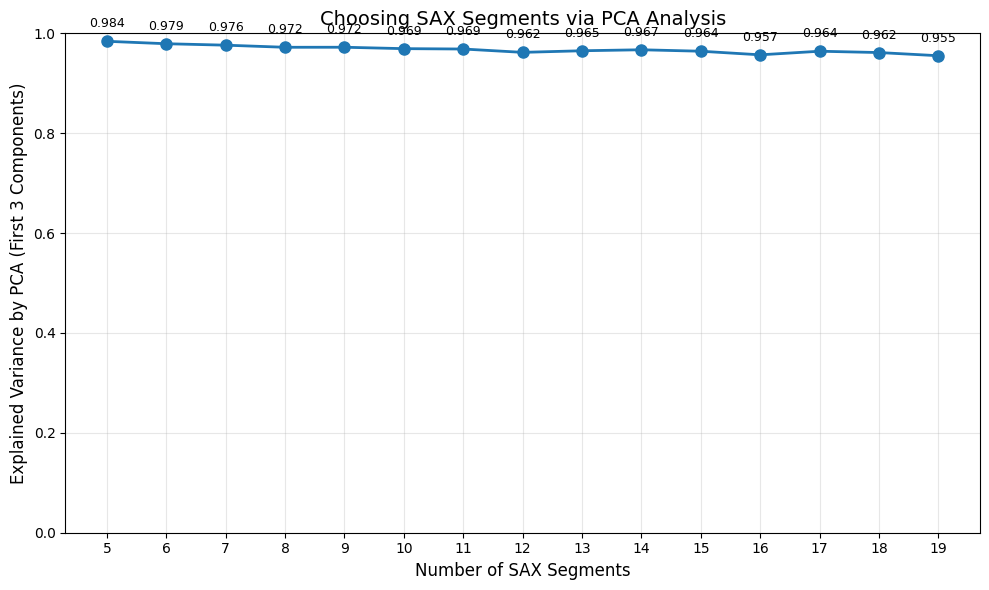


Results Summary:
----------------------------------------
Segments:  5 | Explained Variance: 0.9841
Segments:  6 | Explained Variance: 0.9792
Segments:  7 | Explained Variance: 0.9763
Segments:  8 | Explained Variance: 0.9721
Segments:  9 | Explained Variance: 0.9721
Segments: 10 | Explained Variance: 0.9693
Segments: 11 | Explained Variance: 0.9686
Segments: 12 | Explained Variance: 0.9619
Segments: 13 | Explained Variance: 0.9651
Segments: 14 | Explained Variance: 0.9671
Segments: 15 | Explained Variance: 0.9642
Segments: 16 | Explained Variance: 0.9570
Segments: 17 | Explained Variance: 0.9642
Segments: 18 | Explained Variance: 0.9615
Segments: 19 | Explained Variance: 0.9552

Suggested optimal number of segments: 16


In [18]:
# Ensure X is a NumPy array of shape (n_samples, n_timestamps)
X = norm_energy

print(f"Data shape: {X.shape}")

# Validate data shape
if X.ndim == 1:
    # If 1D, reshape to (1, n_timestamps)
    X = X.reshape(1, -1)
    print(f"Reshaped data to: {X.shape}")

# Try different number of segments
segment_range = range(5, 20)
explained_variances = []

for n_segments in segment_range:
    try:
        print(f"Processing {n_segments} segments...")
        
        # Apply SAX (this creates symbolic representation)
        sax = SymbolicAggregateApproximation(n_bins=n_segments)
        X_sax = sax.fit_transform(X)
        
        # Use PAA to convert time series to numeric representation for PCA
        # Try using the manual implementation
        X_paa = tf.piecewise_aggregate_approximation(X, n_segments)
        
        print(f"PAA shape: {X_paa.shape}")
        
        # Run PCA
        pca = PCA()
        pca.fit(X_paa)
        
        # Record cumulative explained variance by first few components
        # Ensure we don't try to access more components than available
        n_components = min(3, X_paa.shape[1])
        explained_var = np.sum(pca.explained_variance_ratio_[:n_components])
        explained_variances.append(explained_var)
        
        print(f"Explained variance (first {n_components} components): {explained_var:.4f}")
        
    except Exception as e:
        print(f"Error with {n_segments} segments: {e}")
        explained_variances.append(0)  # Add 0 if there's an error

# Plot to find elbow point
plt.figure(figsize=(10, 6))
plt.plot(segment_range, explained_variances, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of SAX Segments', fontsize=12)
plt.ylabel('Explained Variance by PCA (First 3 Components)', fontsize=12)
plt.title('Choosing SAX Segments via PCA Analysis', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(segment_range)
plt.ylim(0, 1)

# Add value labels on points
for i, (x, y) in enumerate(zip(segment_range, explained_variances)):
    plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print results summary
print("\nResults Summary:")
print("-" * 40)
for segments, variance in zip(segment_range, explained_variances):
    print(f"Segments: {segments:2d} | Explained Variance: {variance:.4f}")

# Find optimal number of segments (elbow point)
if len(explained_variances) > 1:
    # Simple elbow detection: find point with maximum second derivative
    second_derivatives = []
    for i in range(1, len(explained_variances)-1):
        second_deriv = explained_variances[i-1] - 2*explained_variances[i] + explained_variances[i+1]
        second_derivatives.append(second_deriv)
    
    if second_derivatives:
        optimal_idx = np.argmax(second_derivatives) + 1
        optimal_segments = list(segment_range)[optimal_idx]
        print(f"\nSuggested optimal number of segments: {optimal_segments}")

In [19]:
# As per the elbow method segments = 10 is the best option
tf.paa_segments = optimal_segments
sax_eval_df = tf.evaluate_alphabet_sizes(norm_energy, alphabet_range=range(3, 7))

In [20]:
sax_eval_df.sort_values(by=['composite_score'], ascending=[False])

alphabet_size  paa_segments   entropy  compression_ratio  uniformity_score  \
3              6            16  2.547874              128.0                 0   
2              5            16  2.295460              128.0                 0   
1              4            16  1.975048              192.0                 0   
0              3            16  1.568602              192.0                 0   

   reconstruction_error  pattern_complexity  information_loss  \
3              1.081190            0.000296          0.000000   
2              1.092321            0.000188          0.000000   
1              1.103471            0.000106          0.000000   
0              1.120419            0.000049          0.341065   

   discriminative_power  composite_score  
3              0.491434         0.548094  
2              0.374121         0.529085  
1              0.254992         0.506594  
0              0.152258         0.429209

In [21]:
tf.alphabet_size = 6

In [22]:
day_to_check = random.randint(0, len(norm_energy))

print(day_to_check)
# 2362 for working reference

12007


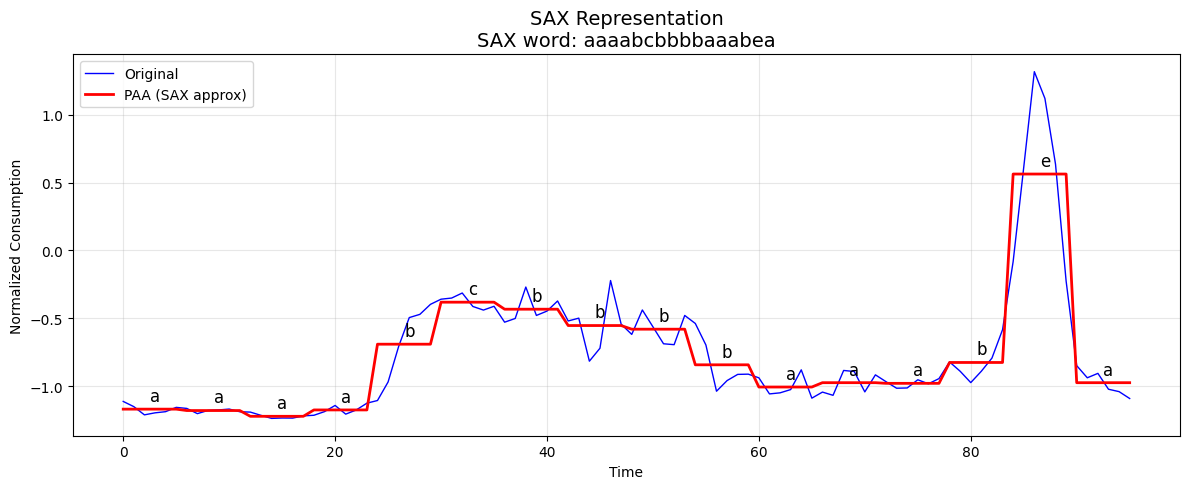

In [23]:
sample_series = norm_energy[day_to_check]  # use another index if you like
tf.plot_sax_visual(sample_series)

In [24]:
sax_output = tf.apply_sax(norm_energy)

**Finding Best PCA configuration**

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

import pandas as pd

def find_optimal_pca_components(data, max_components=None, methods='all'):
    """
    Find optimal number of PCA components using multiple methods.
    
    Args:
        data: 2D numpy array (n_samples, n_features)
        max_components: Maximum number of components to test (default: min(n_samples, n_features))
        methods: str or list - which methods to use ('all', 'variance', 'elbow', 'kaiser', etc.)
    
    Returns:
        dict: Results from different methods
    """
    
    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    n_samples, n_features = data_scaled.shape
    max_components = max_components or min(n_samples, n_features)
    max_components = min(max_components, min(n_samples, n_features))
    
    results = {}
    
    # Fit PCA with all components
    pca_full = PCA(n_components=max_components)
    pca_full.fit(data_scaled)
    
    explained_variance_ratio = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    if methods == 'all' or 'variance' in methods:
        results.update(_variance_threshold_methods(explained_variance_ratio, cumulative_variance))
    
    if methods == 'all' or 'elbow' in methods:
        results.update(_elbow_methods(explained_variance_ratio, cumulative_variance))
    
    if methods == 'all' or 'kaiser' in methods:
        results['kaiser_criterion'] = _kaiser_criterion(pca_full.explained_variance_)
    
    if methods == 'all' or 'broken_stick' in methods:
        results['broken_stick'] = _broken_stick_method(explained_variance_ratio)
    
    if methods == 'all' or 'parallel' in methods:
        results['parallel_analysis'] = _parallel_analysis(data_scaled, max_components)
    
    if methods == 'all' or 'cross_validation' in methods:
        results['cross_validation'] = _cross_validation_method(data_scaled, max_components)
    
    if methods == 'all' or 'information_criteria' in methods:
        results.update(_information_criteria_methods(data_scaled, max_components))
    
    # Summary
    results['explained_variance_ratio'] = explained_variance_ratio
    results['cumulative_variance'] = cumulative_variance
    results['summary'] = _create_summary(results)
    
    return results

def _variance_threshold_methods(explained_variance_ratio, cumulative_variance):
    """Methods based on explained variance thresholds."""
    results = {}
    
    # 80% variance threshold
    results['variance_80'] = np.argmax(cumulative_variance >= 0.80) + 1
    
    # 90% variance threshold
    results['variance_90'] = np.argmax(cumulative_variance >= 0.90) + 1
    
    # 95% variance threshold
    results['variance_95'] = np.argmax(cumulative_variance >= 0.95) + 1
    
    # Significant components (>1% individual variance)
    results['significant_1pct'] = np.sum(explained_variance_ratio > 0.01)
    
    # Significant components (>5% individual variance)
    results['significant_5pct'] = np.sum(explained_variance_ratio > 0.05)
    
    return results

def _elbow_methods(explained_variance_ratio, cumulative_variance):
    """Elbow method and variants."""
    results = {}
    
    # Manual elbow detection methods
    results['elbow_variance'] = _manual_elbow_detection(explained_variance_ratio)
    results['elbow_cumulative'] = _manual_elbow_detection(cumulative_variance, increasing=True)
    results['elbow_second_derivative'] = _second_derivative_elbow(explained_variance_ratio)
    results['elbow_distance'] = _distance_based_elbow(explained_variance_ratio)
    
    return results

def _manual_elbow_detection(values, increasing=False):
    """Manual elbow detection using second derivative."""
    if len(values) < 3:
        return 1
    
    # Calculate second derivative
    second_derivative = np.diff(values, 2)
    
    if increasing:
        # For increasing curves, find where second derivative is most negative
        elbow_idx = np.argmin(second_derivative) + 2
    else:
        # For decreasing curves, find where second derivative is most positive
        elbow_idx = np.argmax(second_derivative) + 2
    
    return min(elbow_idx, len(values))

def _second_derivative_elbow(values):
    """Find elbow using second derivative analysis."""
    if len(values) < 3:
        return 1
    
    # Calculate first and second derivatives
    first_derivative = np.diff(values)
    second_derivative = np.diff(first_derivative)
    
    # Find the point where second derivative is maximum (biggest change in slope)
    elbow_idx = np.argmax(np.abs(second_derivative)) + 2
    return min(elbow_idx, len(values))

def _distance_based_elbow(values):
    """Find elbow using perpendicular distance method."""
    if len(values) < 3:
        return 1
    
    n_components = len(values)
    
    # Create line from first to last point
    x = np.array(range(n_components))
    y = np.array(values)
    
    # Line from first to last point: y = mx + b
    x1, y1 = 0, y[0]
    x2, y2 = n_components - 1, y[-1]
    
    if x2 - x1 == 0:  # Avoid division by zero
        return 1
    
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    
    # Calculate perpendicular distance from each point to the line
    distances = []
    for i in range(n_components):
        # Distance from point (x[i], y[i]) to line mx - y + b = 0
        distance = abs(m * x[i] - y[i] + b) / np.sqrt(m**2 + 1)
        distances.append(distance)
    
    # Find the point with maximum distance
    elbow_idx = np.argmax(distances)
    return elbow_idx + 1

def _kaiser_criterion(eigenvalues):
    """Kaiser criterion: keep components with eigenvalues > 1."""
    return np.sum(eigenvalues > 1.0)

def _broken_stick_method(explained_variance_ratio):
    """Broken stick method for component selection."""
    n_components = len(explained_variance_ratio)
    
    # Calculate broken stick distribution
    broken_stick = []
    for i in range(n_components):
        stick_value = sum(1/j for j in range(i+1, n_components+1)) / n_components
        broken_stick.append(stick_value)
    
    # Find components where observed variance > broken stick expectation
    significant = explained_variance_ratio > broken_stick
    return np.sum(significant)

def _parallel_analysis(data, max_components):
    """Parallel analysis method."""
    n_samples, n_features = data.shape
    n_iterations = 100
    
    # Generate random data eigenvalues
    random_eigenvalues = []
    for _ in range(n_iterations):
        random_data = np.random.normal(0, 1, (n_samples, n_features))
        pca_random = PCA(n_components=max_components)
        pca_random.fit(random_data)
        random_eigenvalues.append(pca_random.explained_variance_)
    
    # Calculate mean eigenvalues from random data
    mean_random_eigenvalues = np.mean(random_eigenvalues, axis=0)
    
    # Fit PCA on real data
    pca_real = PCA(n_components=max_components)
    pca_real.fit(data)
    real_eigenvalues = pca_real.explained_variance_
    
    # Count components where real eigenvalues > random eigenvalues
    significant = real_eigenvalues > mean_random_eigenvalues
    return np.sum(significant)

def _cross_validation_method(data, max_components, cv=5):
    """Cross-validation based method using reconstruction error."""
    from sklearn.model_selection import KFold
    
    cv_scores = []
    components_range = range(1, min(max_components + 1, data.shape[1]))
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    for n_comp in components_range:
        scores = []
        for train_idx, test_idx in kf.split(data):
            X_train, X_test = data[train_idx], data[test_idx]
            
            # Fit PCA on training data
            pca = PCA(n_components=n_comp)
            X_train_pca = pca.fit_transform(X_train)
            
            # Transform and reconstruct test data
            X_test_pca = pca.transform(X_test)
            X_test_reconstructed = pca.inverse_transform(X_test_pca)
            
            # Calculate reconstruction error
            reconstruction_error = np.mean((X_test - X_test_reconstructed) ** 2)
            scores.append(-reconstruction_error)  # Negative because we want to minimize error
        
        cv_scores.append(np.mean(scores))
    
    # Find the number of components with best CV score
    optimal_components = components_range[np.argmax(cv_scores)]
    return optimal_components

def _information_criteria_methods(data, max_components):
    """Information criteria methods (AIC, BIC)."""
    results = {}
    n_samples, n_features = data.shape
    
    aic_scores = []
    bic_scores = []
    
    for n_comp in range(1, min(max_components + 1, n_features)):
        pca = PCA(n_components=n_comp)
        X_transformed = pca.fit_transform(data)
        X_reconstructed = pca.inverse_transform(X_transformed)
        
        # Calculate reconstruction error (log-likelihood proxy)
        mse = np.mean((data - X_reconstructed) ** 2)
        log_likelihood = -n_samples * n_features * np.log(mse) / 2
        
        # Number of parameters
        n_params = n_comp * (n_features + n_samples - n_comp)
        
        # Calculate AIC and BIC
        aic = -2 * log_likelihood + 2 * n_params
        bic = -2 * log_likelihood + np.log(n_samples) * n_params
        
        aic_scores.append(aic)
        bic_scores.append(bic)
    
    results['aic_optimal'] = np.argmin(aic_scores) + 1
    results['bic_optimal'] = np.argmin(bic_scores) + 1
    
    return results

def _create_summary(results):
    """Create summary of all methods."""
    summary = {}
    
    # Extract numeric results
    numeric_results = {k: v for k, v in results.items() 
                      if isinstance(v, (int, np.integer)) and k not in ['explained_variance_ratio', 'cumulative_variance']}
    
    if numeric_results:
        values = list(numeric_results.values())
        summary['mean'] = np.mean(values)
        summary['median'] = np.median(values)
        summary['mode'] = max(set(values), key=values.count)
        summary['min'] = min(values)
        summary['max'] = max(values)
        summary['std'] = np.std(values)
        summary['methods_count'] = len(numeric_results)
        summary['recommendations'] = numeric_results
    
    return summary

def plot_pca_analysis(results, save_path=None):
    """Plot PCA analysis results."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    explained_var = results['explained_variance_ratio']
    cumulative_var = results['cumulative_variance']
    components = range(1, len(explained_var) + 1)
    
    # Plot 1: Explained variance ratio
    axes[0, 0].bar(components, explained_var)
    axes[0, 0].set_title('Explained Variance Ratio by Component')
    axes[0, 0].set_xlabel('Principal Component')
    axes[0, 0].set_ylabel('Explained Variance Ratio')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Cumulative explained variance
    axes[0, 1].plot(components, cumulative_var, 'bo-')
    axes[0, 1].axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='80%')
    axes[0, 1].axhline(y=0.9, color='g', linestyle='--', alpha=0.7, label='90%')
    axes[0, 1].axhline(y=0.95, color='orange', linestyle='--', alpha=0.7, label='95%')
    axes[0, 1].set_title('Cumulative Explained Variance')
    axes[0, 1].set_xlabel('Principal Component')
    axes[0, 1].set_ylabel('Cumulative Explained Variance')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Scree plot with elbow detection
    axes[1, 0].plot(components, explained_var, 'bo-')
    if 'elbow_variance' in results:
        axes[1, 0].axvline(x=results['elbow_variance'], color='r', linestyle='--', 
                          label=f'Elbow at {results["elbow_variance"]}')
    axes[1, 0].set_title('Scree Plot')
    axes[1, 0].set_xlabel('Principal Component')
    axes[1, 0].set_ylabel('Explained Variance Ratio')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Methods comparison
    summary = results.get('summary', {})
    if 'recommendations' in summary:
        methods = list(summary['recommendations'].keys())
        values = list(summary['recommendations'].values())
        
        axes[1, 1].barh(methods, values)
        axes[1, 1].set_title('Component Recommendations by Method')
        axes[1, 1].set_xlabel('Number of Components')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Add median line
        if 'median' in summary:
            axes[1, 1].axvline(x=summary['median'], color='r', linestyle='--', 
                              label=f'Median: {summary["median"]:.1f}')
            axes[1, 1].legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def print_pca_recommendations(results):
    """Print formatted recommendations."""
    print("PCA Component Selection Results")
    print("=" * 50)
    
    # Variance-based methods
    print("\nVariance-based Methods:")
    variance_methods = ['variance_80', 'variance_90', 'variance_95', 'significant_1pct', 'significant_5pct']
    for method in variance_methods:
        if method in results:
            print(f"  • {method.replace('_', ' ').title()}: {results[method]} components")
    
    # Elbow methods
    print("\nElbow Methods:")
    elbow_methods = ['elbow_variance', 'elbow_cumulative', 'elbow_second_derivative', 'elbow_distance']
    for method in elbow_methods:
        if method in results:
            print(f"  • {method.replace('_', ' ').title()}: {results[method]} components")
    
    # Statistical methods
    print("\nStatistical Methods:")
    stat_methods = ['kaiser_criterion', 'broken_stick', 'parallel_analysis']
    for method in stat_methods:
        if method in results:
            print(f"  • {method.replace('_', ' ').title()}: {results[method]} components")
    
    # Advanced methods
    print("\nAdvanced Methods:")
    advanced_methods = ['cross_validation', 'aic_optimal', 'bic_optimal']
    for method in advanced_methods:
        if method in results:
            print(f"  • {method.replace('_', ' ').title()}: {results[method]} components")
    
    # Summary
    if 'summary' in results and 'recommendations' in results['summary']:
        summary = results['summary']
        print(f"\nSummary Statistics:")
        print(f"  • Mean recommendation: {summary['mean']:.1f} components")
        print(f"  • Median recommendation: {summary['median']:.1f} components")
        print(f"  • Most common: {summary['mode']} components")
        print(f"  • Range: {summary['min']}-{summary['max']} components")
        print(f"  • Standard deviation: {summary['std']:.2f}")
        
        print(f"\nRecommended: {int(summary['median'])} components")
        print(f"   (Based on median of {summary['methods_count']} methods)")

In [26]:
# Find optimal components
results = find_optimal_pca_components(norm_energy, max_components=15)

In [27]:
# Print recommendations
print_pca_recommendations(results)

PCA Component Selection Results

Variance-based Methods:
  • Variance 80: 2 components
  • Variance 90: 3 components
  • Variance 95: 4 components
  • Significant 1Pct: 5 components
  • Significant 5Pct: 3 components

Elbow Methods:
  • Elbow Variance: 2 components
  • Elbow Cumulative: 3 components
  • Elbow Second Derivative: 2 components
  • Elbow Distance: 2 components

Statistical Methods:
  • Kaiser Criterion: 5 components
  • Broken Stick: 1 components
  • Parallel Analysis: 4 components

Advanced Methods:
  • Cross Validation: 15 components
  • Aic Optimal: 15 components
  • Bic Optimal: 9 components

Summary Statistics:
  • Mean recommendation: 5.0 components
  • Median recommendation: 3.0 components
  • Most common: 2 components
  • Range: 1-15 components
  • Standard deviation: 4.34

Recommended: 3 components
   (Based on median of 15 methods)


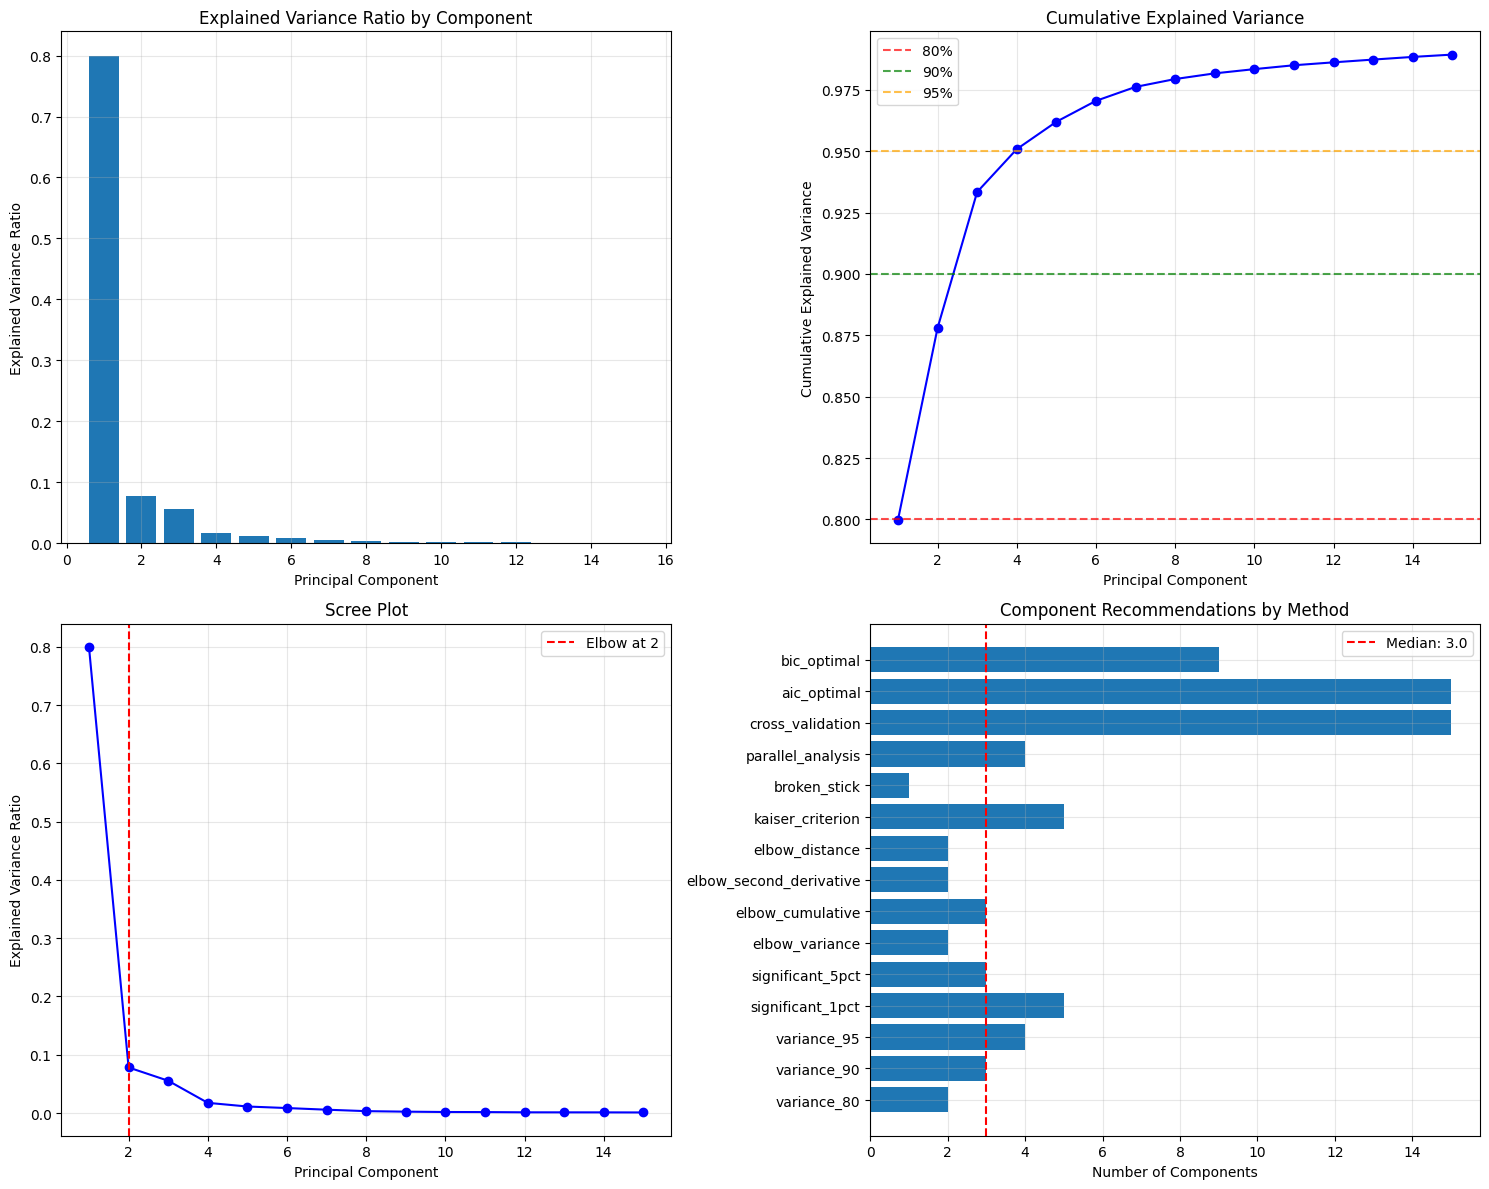

In [28]:
# Plot analysis
plot_pca_analysis(results)

In [29]:
tf.n_components = 2

In [30]:
pca_result = tf.apply_pca(energy_normal)
pca_result_z = tf.apply_pca(norm_energy)

**SAX+PCA**

In [31]:
sax_pca = tf.apply_pca(sax_output)

**Clustering**

In [32]:
ks = range(3, 7)

In [33]:
def plot_pca_cluster(k_range, input_arr):
    fig, axes = plt.subplots(len(k_range), 2, figsize=(10, len(k_range) * 6), sharex=False, sharey=False)

    for i, k in enumerate(k_range):
        km = KMeans(n_clusters=k, random_state=0).fit(input_arr)
        labels = km.labels_
        
        ax0 = axes[i, 0]
        sns.scatterplot(x=input_arr[:, 0], y=input_arr[:, 1], hue=labels,
                        palette="tab10", s=20, ax=ax0, legend=False)
        
        sil = silhouette_score(input_arr, labels)
        db_score = davies_bouldin_score(input_arr, labels)

        ax0.set_title(f"k={k}\nSilhouette={sil:.3f}  DBS={db_score:.3f}")
        ax0.set_xlabel("PC1")
        ax0.set_ylabel("PC2")

        ax1 = axes[i, 1]
        sample_sil = silhouette_samples(input_arr, labels)
        y_lower = 10
        for cluster in range(k):
            clust_sil = sample_sil[labels == cluster]
            clust_sil.sort()
            size = clust_sil.shape[0]
            y_upper = y_lower + size
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0, clust_sil, alpha=0.7
            )
            ax1.text(-0.05, y_lower + size / 2, str(cluster))
            y_lower = y_upper + 10

        ax1.set_title("Silhouette per sample")
        ax1.set_xlabel("Silhouette Coefficient")
        ax1.set_ylabel("Samples (Clustered)")

    plt.tight_layout()
    plt.show()

**Plotting PCA clustered on normalised data**

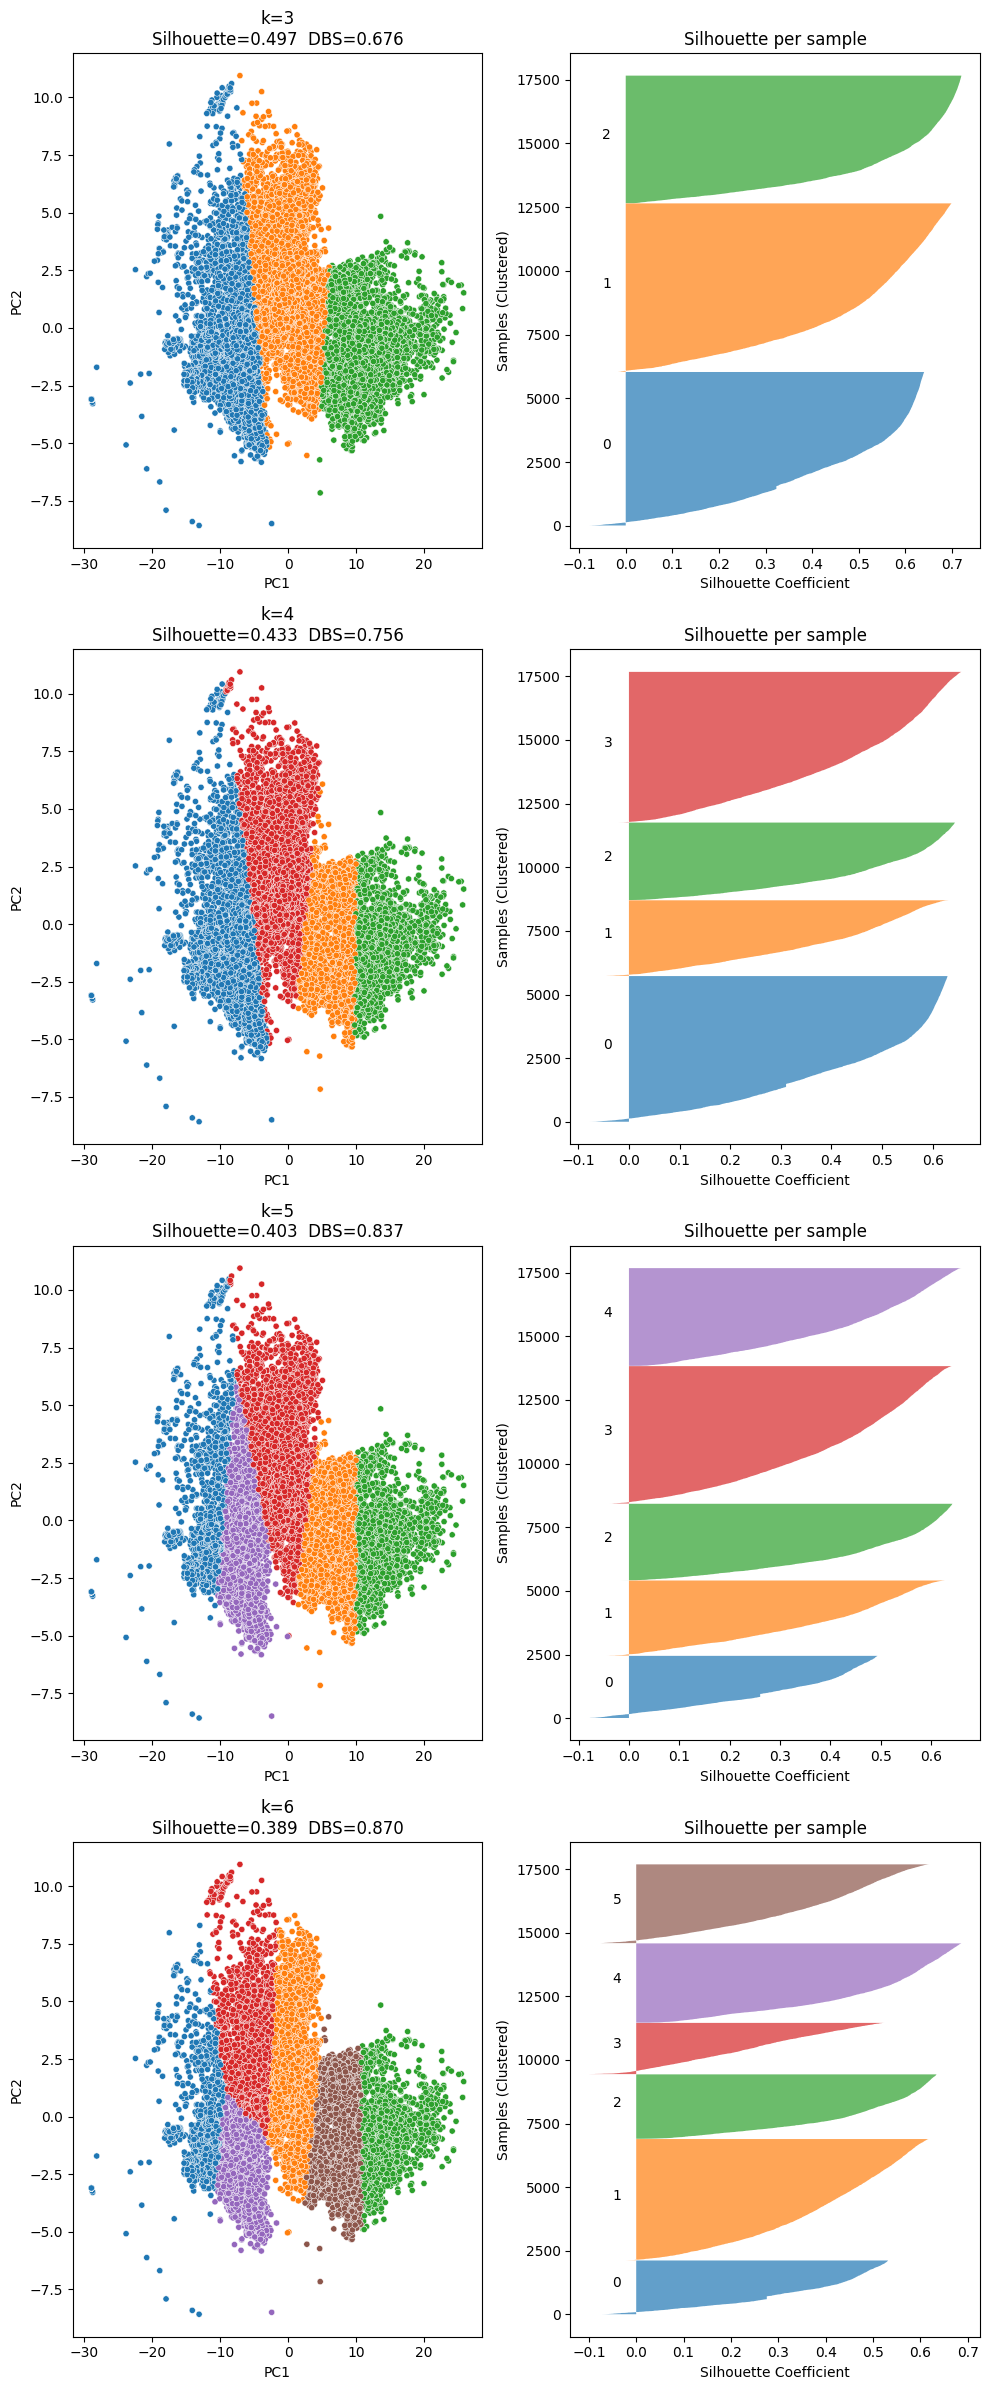

In [34]:
plot_pca_cluster(ks, pca_result)

**Plotting Z-score normalised PCA**

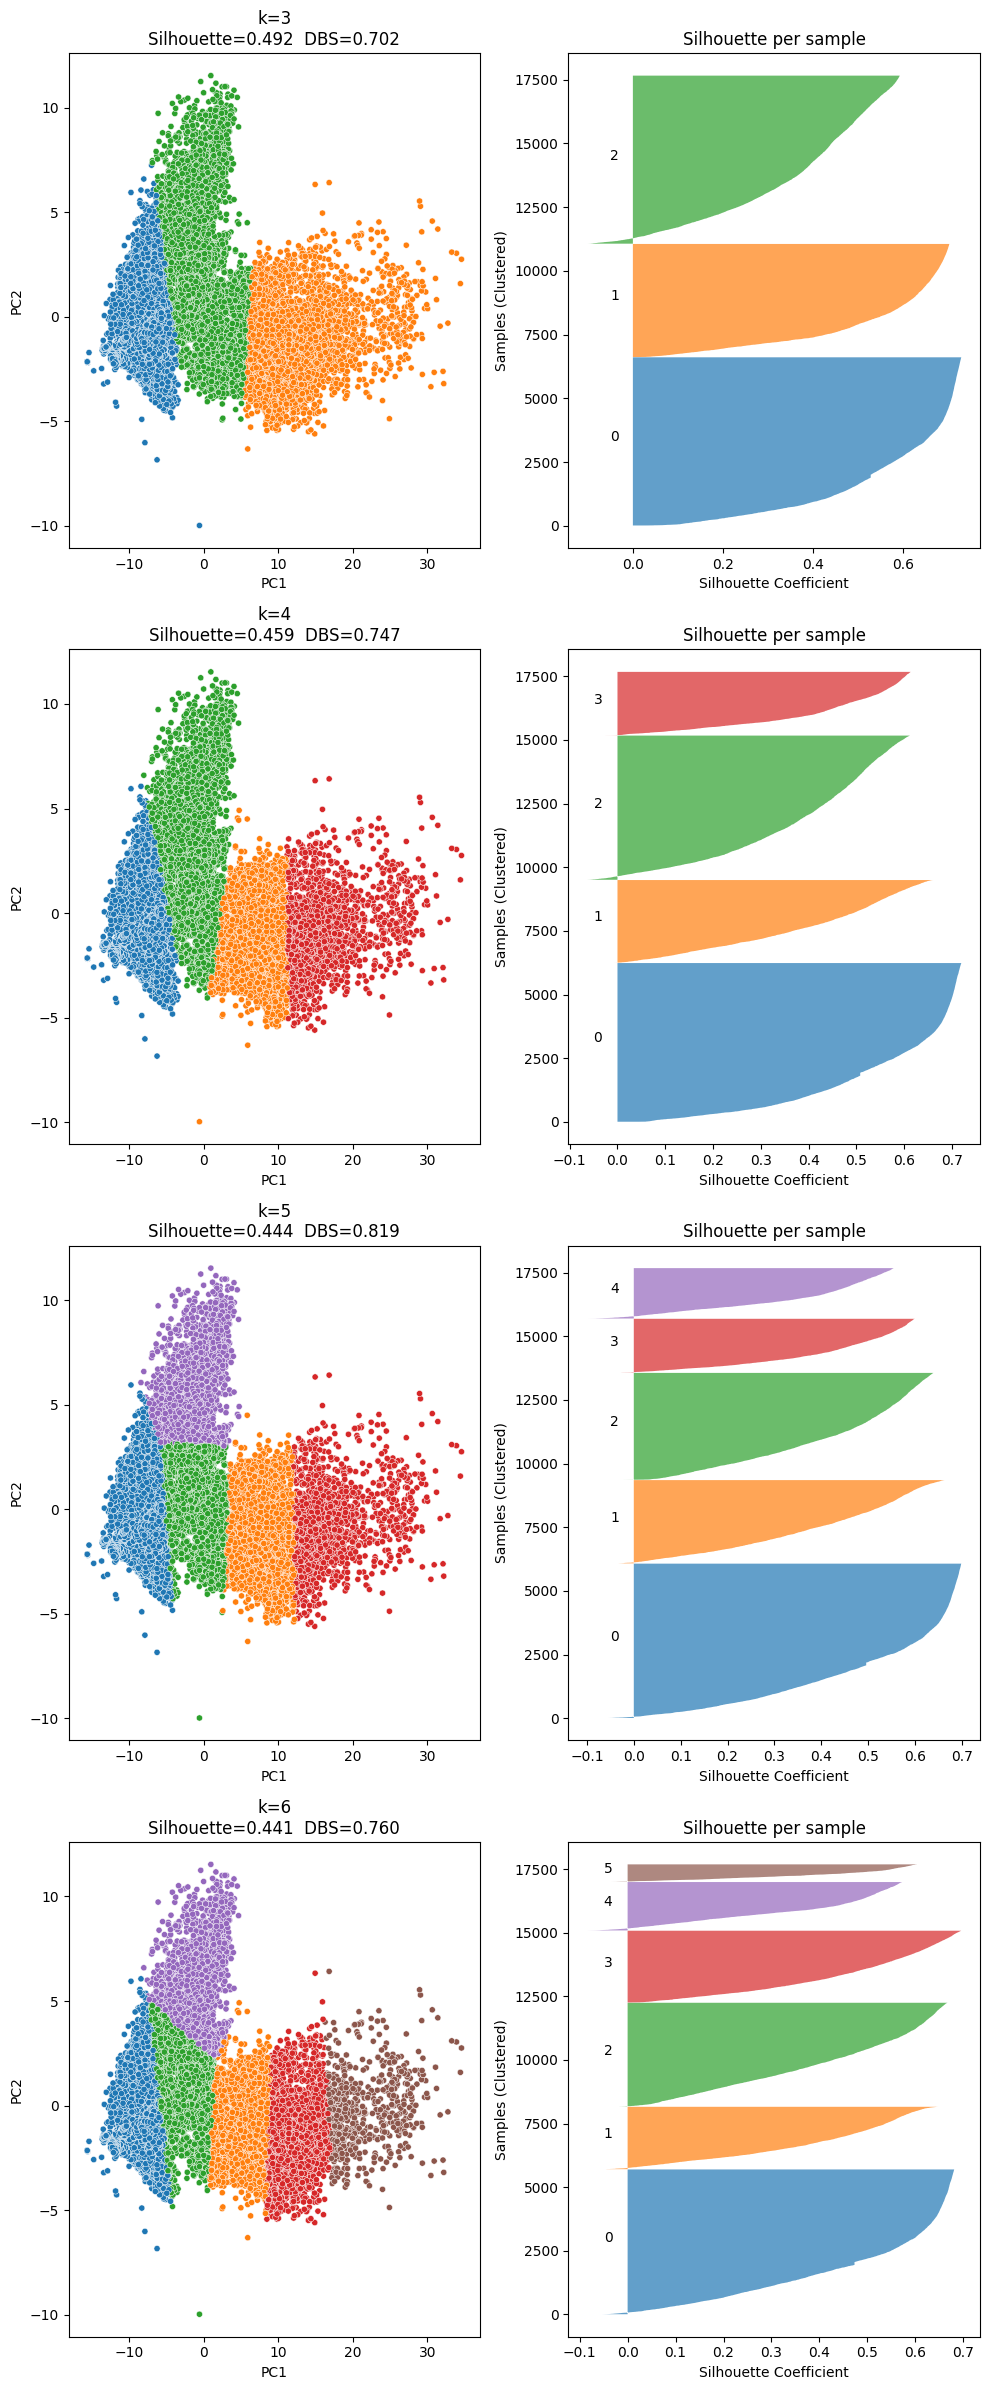

In [35]:
plot_pca_cluster(ks, pca_result_z)

**Clustering SAX+PCA data**

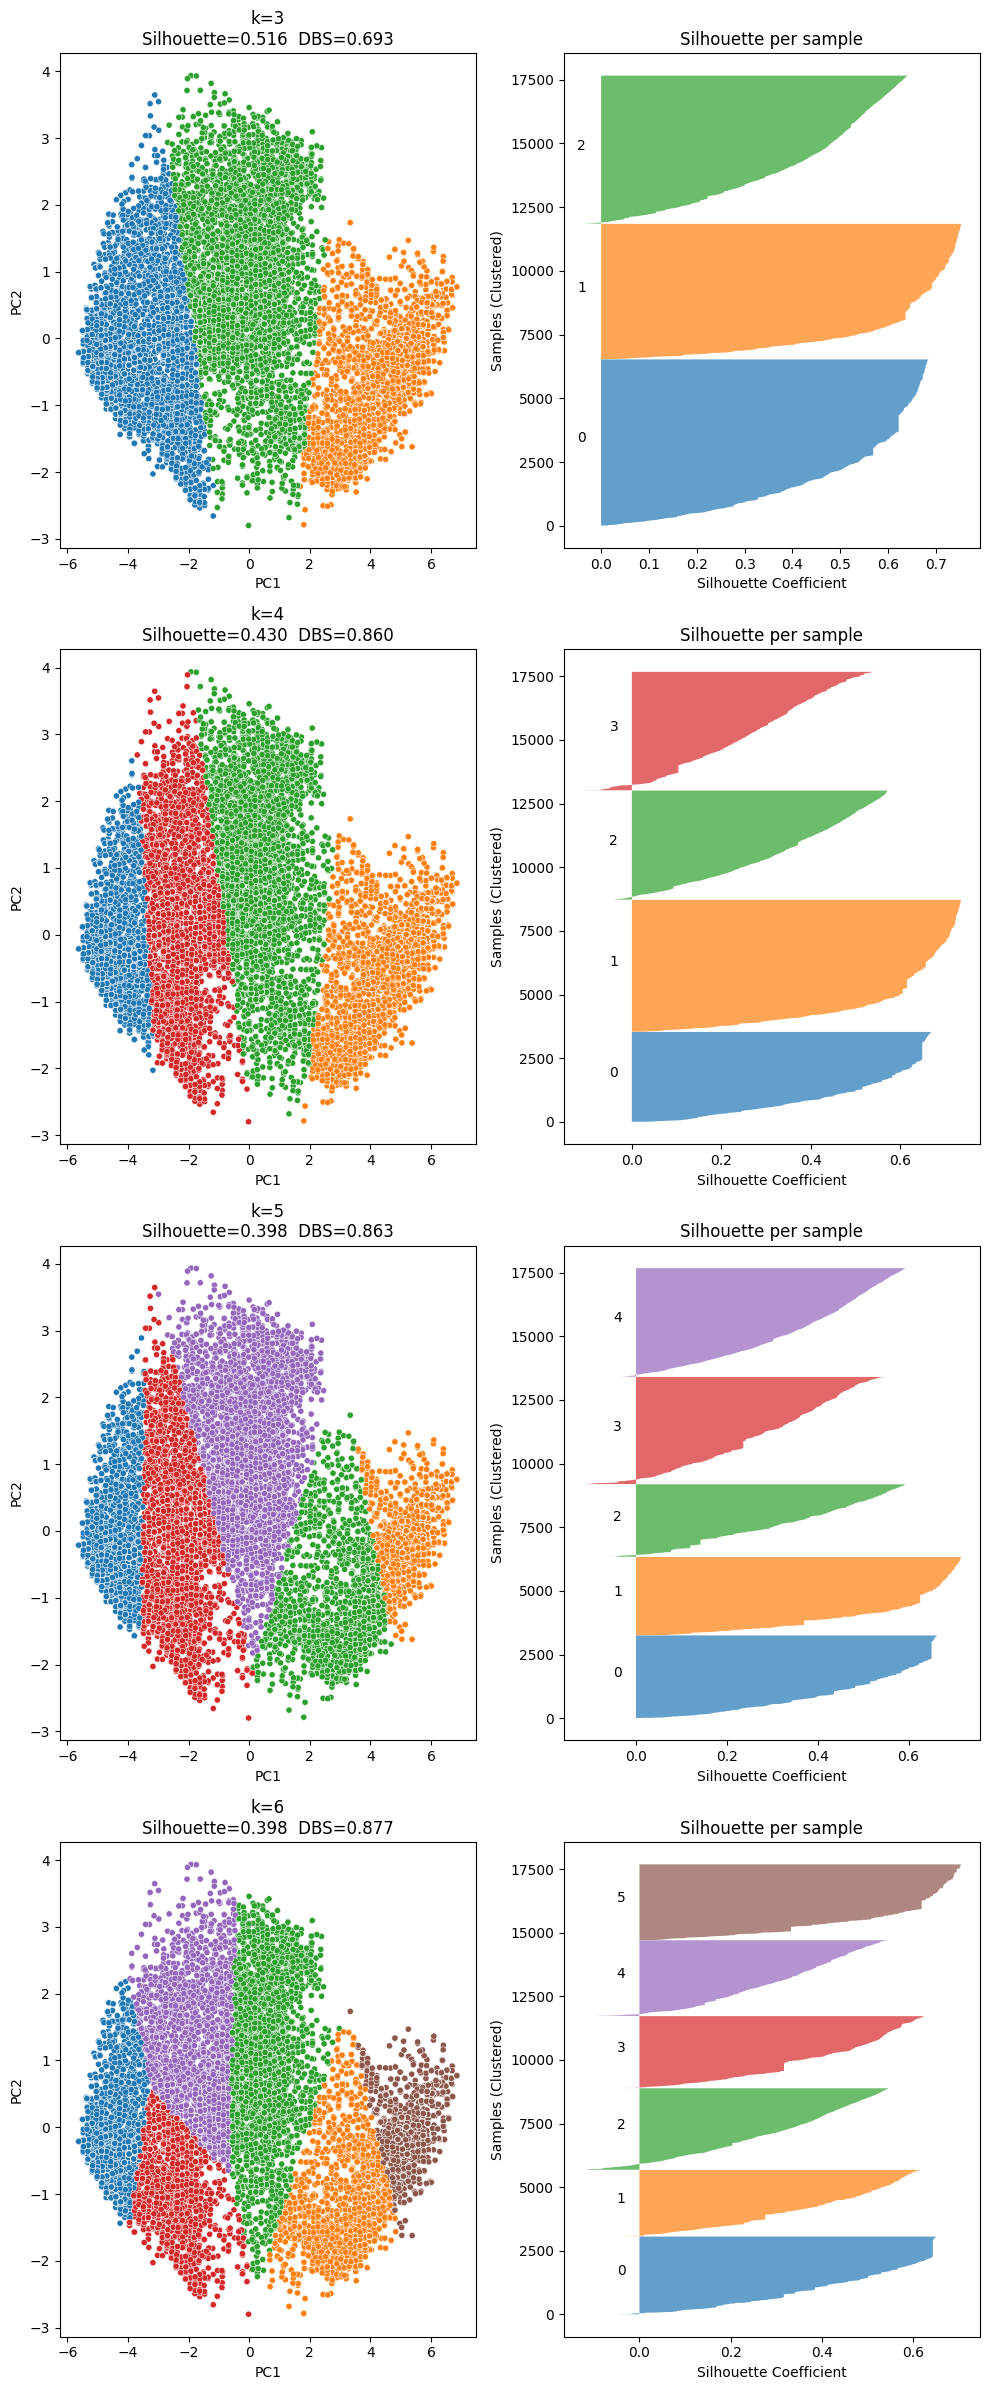

In [36]:
plot_pca_cluster(ks, sax_pca)

**Clustering SAX output**

In [37]:
for k in ks:
    km_sax = KMeans(n_clusters=k, random_state=0).fit(sax_output)
    labels_sax = km_sax.labels_
    print(f'k:{k}\n\tSilhouette:{silhouette_score(sax_output, labels_sax)}\n\tDavies-Bouldin:{davies_bouldin_score(sax_output, labels_sax)}')

k:3
	Silhouette:0.4002241831575093
	Davies-Bouldin:0.9820572947790591
k:4
	Silhouette:0.3215145292488982
	Davies-Bouldin:1.272422089422038
k:5
	Silhouette:0.2912950910647705
	Davies-Bouldin:1.254160196144237
k:6
	Silhouette:0.2833745310005752
	Davies-Bouldin:1.2770567578319925


In [38]:
comparison_results = []

methods = {
    "PCA": pca_result,
    "SAX+PCA": sax_pca,
    "SAX": sax_output
}

for method_name, data in methods.items():
    for k in ks:  # ks = range(3, 7)
        kmeans_model = KMeans(n_clusters=k, random_state=0).fit(data)
        labels = kmeans_model.labels_
        
        sil = silhouette_score(data, labels)
        dbs = davies_bouldin_score(data, labels)
        
        comparison_results.append({
            "Method": method_name,
            "k": k,
            "Silhouette": round(sil, 3),
            "Davies-Bouldin": round(dbs, 3)
        })

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_results)

In [39]:
print("\nClustering Performance Summary for Multiple k:")
print(comparison_df.sort_values(by=["Method", "k"]).to_string(index=False))


Clustering Performance Summary for Multiple k:
 Method  k  Silhouette  Davies-Bouldin
    PCA  3       0.497           0.676
    PCA  4       0.433           0.756
    PCA  5       0.403           0.837
    PCA  6       0.389           0.870
    SAX  3       0.400           0.982
    SAX  4       0.322           1.272
    SAX  5       0.291           1.254
    SAX  6       0.283           1.277
SAX+PCA  3       0.516           0.693
SAX+PCA  4       0.430           0.860
SAX+PCA  5       0.398           0.863
SAX+PCA  6       0.398           0.877


In [40]:
def get_kmeans_labels(n_k: int, arr: np.ndarray):
      
      km_sax_final = KMeans(n_clusters=n_k, random_state=0).fit(arr)
      return km_sax_final.labels_

k_final = 5
pca_labels = get_kmeans_labels(k_final, pca_result)
sax_labels = get_kmeans_labels(k_final, sax_output)
sax_pca_labels = get_kmeans_labels(k_final, sax_pca)

# Energy aggregation
energy_sum = energy.reshape(energy.shape[0] // num_intervals, num_intervals)
energy_sum = np.sum(energy_sum, axis=1)

# Build DataFrame with final clustering labels
cluster_np = np.c_[buildings, dates, weekday, months, terms, pca_labels, sax_labels, sax_pca_labels, energy_sum]

cluster_df = pd.DataFrame(cluster_np, columns=['Building', 'Date', 'Weekday', 'Month', 'Term', 'PCA_Labels', 'SAX_Labels', 'SAX+PCA_Labels', 'Energy_KW'])
cluster_df['Date'] = pd.to_datetime(cluster_df['Date'])

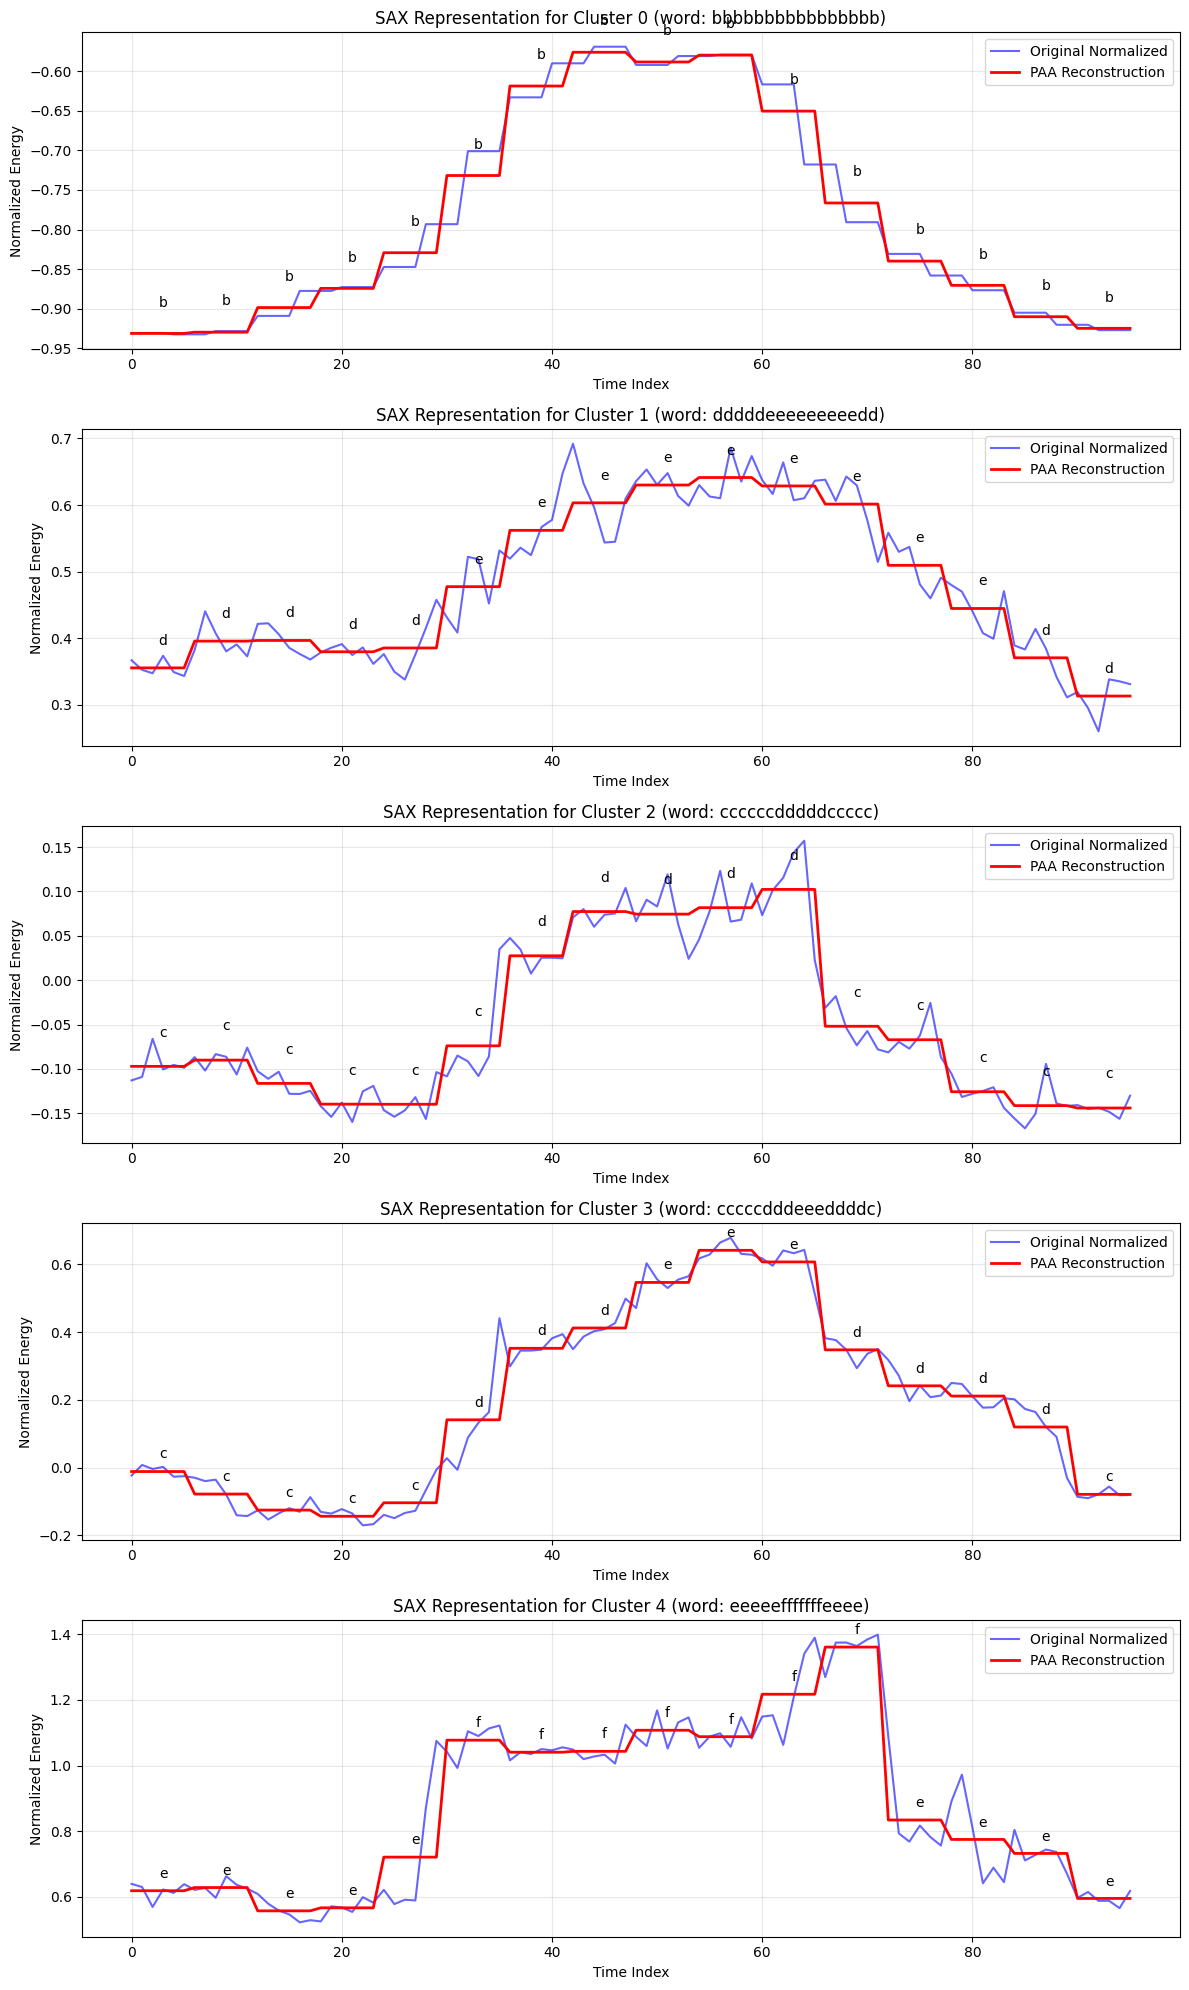

In [41]:
# --- Symbolic SAX Visualization for Each Cluster ---
unique_clusters = np.unique(sax_labels)

fig, axes = plt.subplots(len(unique_clusters), 1, figsize=(12, 4 * len(unique_clusters)))

if len(unique_clusters) == 1:
    axes = [axes]  # Ensure iterable if only one cluster

for idx, cluster in enumerate(unique_clusters):
    cluster_indices = np.where(sax_labels == cluster)[0]
    
    # Pick one representative series (you could also average, but SAX needs actual series)
    representative_series = norm_energy[cluster_indices[0]]
    
    # Apply PAA + SAX to representative
    paa_rep = paa(representative_series, tf.paa_segments)
    cuts = cuts_for_asize(tf.alphabet_size)
    sax_string = ts_to_string(paa_rep, cuts)
    
    # Reconstruct stepwise for visualization
    reconstructed = np.repeat(paa_rep, len(representative_series) // tf.paa_segments)
    
    # Plot original and reconstructed
    ax = axes[idx]
    ax.plot(representative_series, label="Original Normalized", color="blue", alpha=0.6)
    ax.plot(reconstructed, label="PAA Reconstruction", color="red", linewidth=2)
    
    # Annotate SAX symbols
    seg_len = len(representative_series) // tf.paa_segments
    for i, symbol in enumerate(sax_string):
        xpos = i * seg_len + seg_len // 2
        ypos = paa_rep[i]
        ax.text(xpos, ypos + 0.03, symbol, fontsize=10, ha='center', va='bottom', color='black')
    
    ax.set_title(f"SAX Representation for Cluster {cluster} (word: {sax_string})")
    ax.set_xlabel("Time Index")
    ax.set_ylabel("Normalized Energy")
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

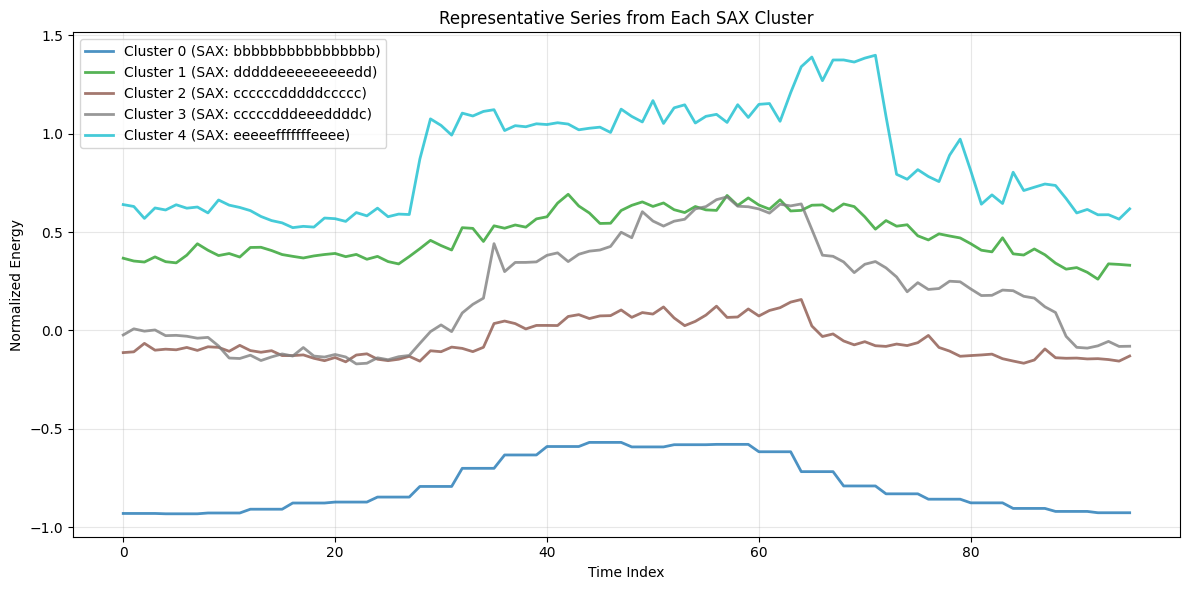

In [42]:
# --- Single Chart SAX Visualization with Representative Series ---
unique_clusters = np.unique(sax_labels)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

for idx, cluster in enumerate(unique_clusters):
    cluster_indices = np.where(sax_labels == cluster)[0]
    
    # Pick one representative series
    representative_series = norm_energy[cluster_indices[0]]
    
    # Apply PAA + SAX to representative
    paa_rep = paa(representative_series, tf.paa_segments)
    cuts = cuts_for_asize(tf.alphabet_size)
    sax_string = ts_to_string(paa_rep, cuts)
    
    # Plot only the original normalized series
    ax.plot(representative_series, 
            label=f"Cluster {cluster} (SAX: {sax_string})", 
            color=colors[idx], 
            linewidth=2,
            alpha=0.8)

ax.set_title("Representative Series from Each SAX Cluster")
ax.set_xlabel("Time Index")
ax.set_ylabel("Normalized Energy")
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

**Clustering PCA output**

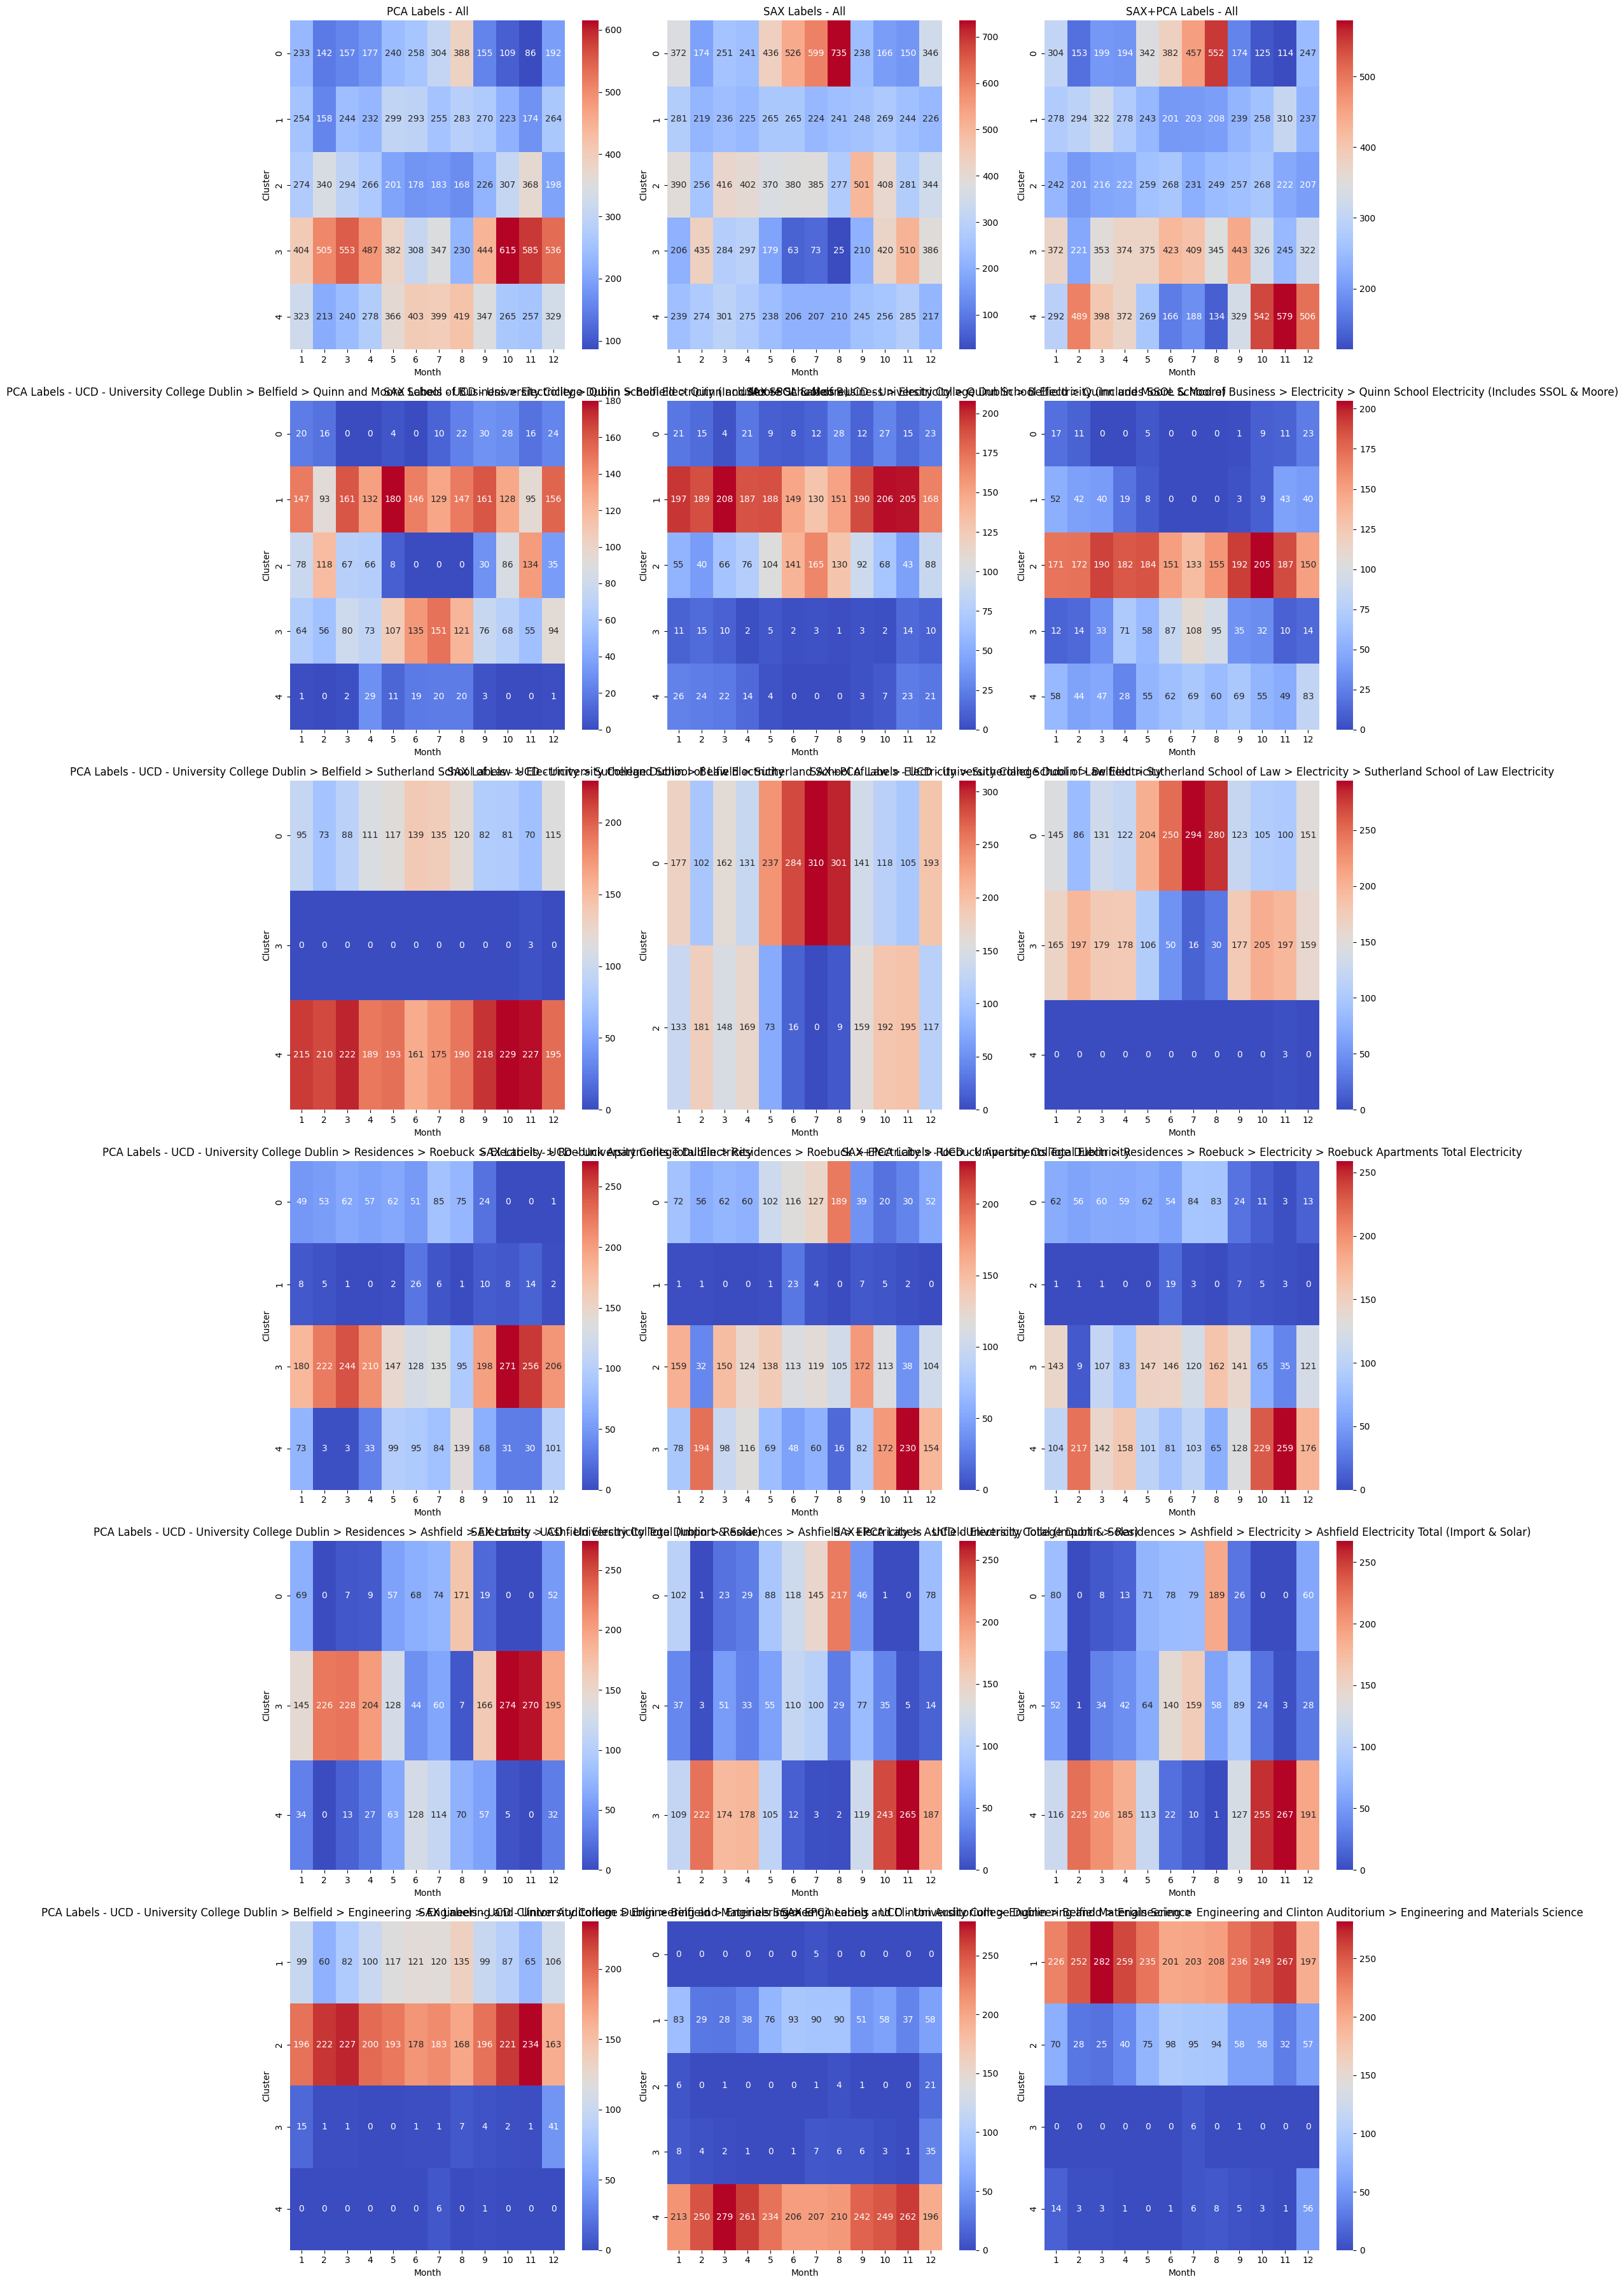

In [43]:
target_buildings = ['All', *target_building]

# Calculate number of buildings for subplot layout
n_buildings = len(target_buildings)

# Create subplots arranged as 3 columns for each building row
fig, axes = plt.subplots(n_buildings, 3, figsize=(18, 6 * n_buildings))

# Handle case where there's only one building (axes won't be a 2D array)
if n_buildings == 1:
    axes = axes.reshape(1, -1)

# Define the label columns and their titles
label_columns = ['PCA_Labels', 'SAX_Labels', 'SAX+PCA_Labels']
titles = ['PCA Labels', 'SAX Labels', 'SAX+PCA Labels']

for idx, building in enumerate(target_buildings):
    
    # Fix the filter condition - check if building is 'All'
    filter_df = cluster_df if building == 'All' else cluster_df[cluster_df['Building'] == building]

    # Ensure Date is numeric
    filter_df = filter_df.copy()  # Avoid SettingWithCopyWarning
    filter_df['Date'] = pd.to_numeric(filter_df['Date'], errors='coerce')

    # Create heatmaps for each label type
    for col_idx, (label_col, title) in enumerate(zip(label_columns, titles)):
        # Create month-cluster summary for heatmap
        heatmap_df = filter_df.groupby(['Month', label_col])['Date'].count().reset_index()

        # Pivot to make Month as columns, Clusters as rows
        heatmap_pivot = heatmap_df.pivot(index=label_col, columns='Month', values='Date')

        # Fill NaN values with 0 and convert to float
        heatmap_pivot = heatmap_pivot.fillna(0).astype(float)

        # Plot heatmap on the specific subplot
        sns.heatmap(heatmap_pivot, cmap="coolwarm", annot=True, fmt=".0f", ax=axes[idx, col_idx])
        
        # Set title - simplified version
        axes[idx, col_idx].set_title(f"{title} - {building}")
        axes[idx, col_idx].set_xlabel("Month")
        axes[idx, col_idx].set_ylabel("Cluster")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

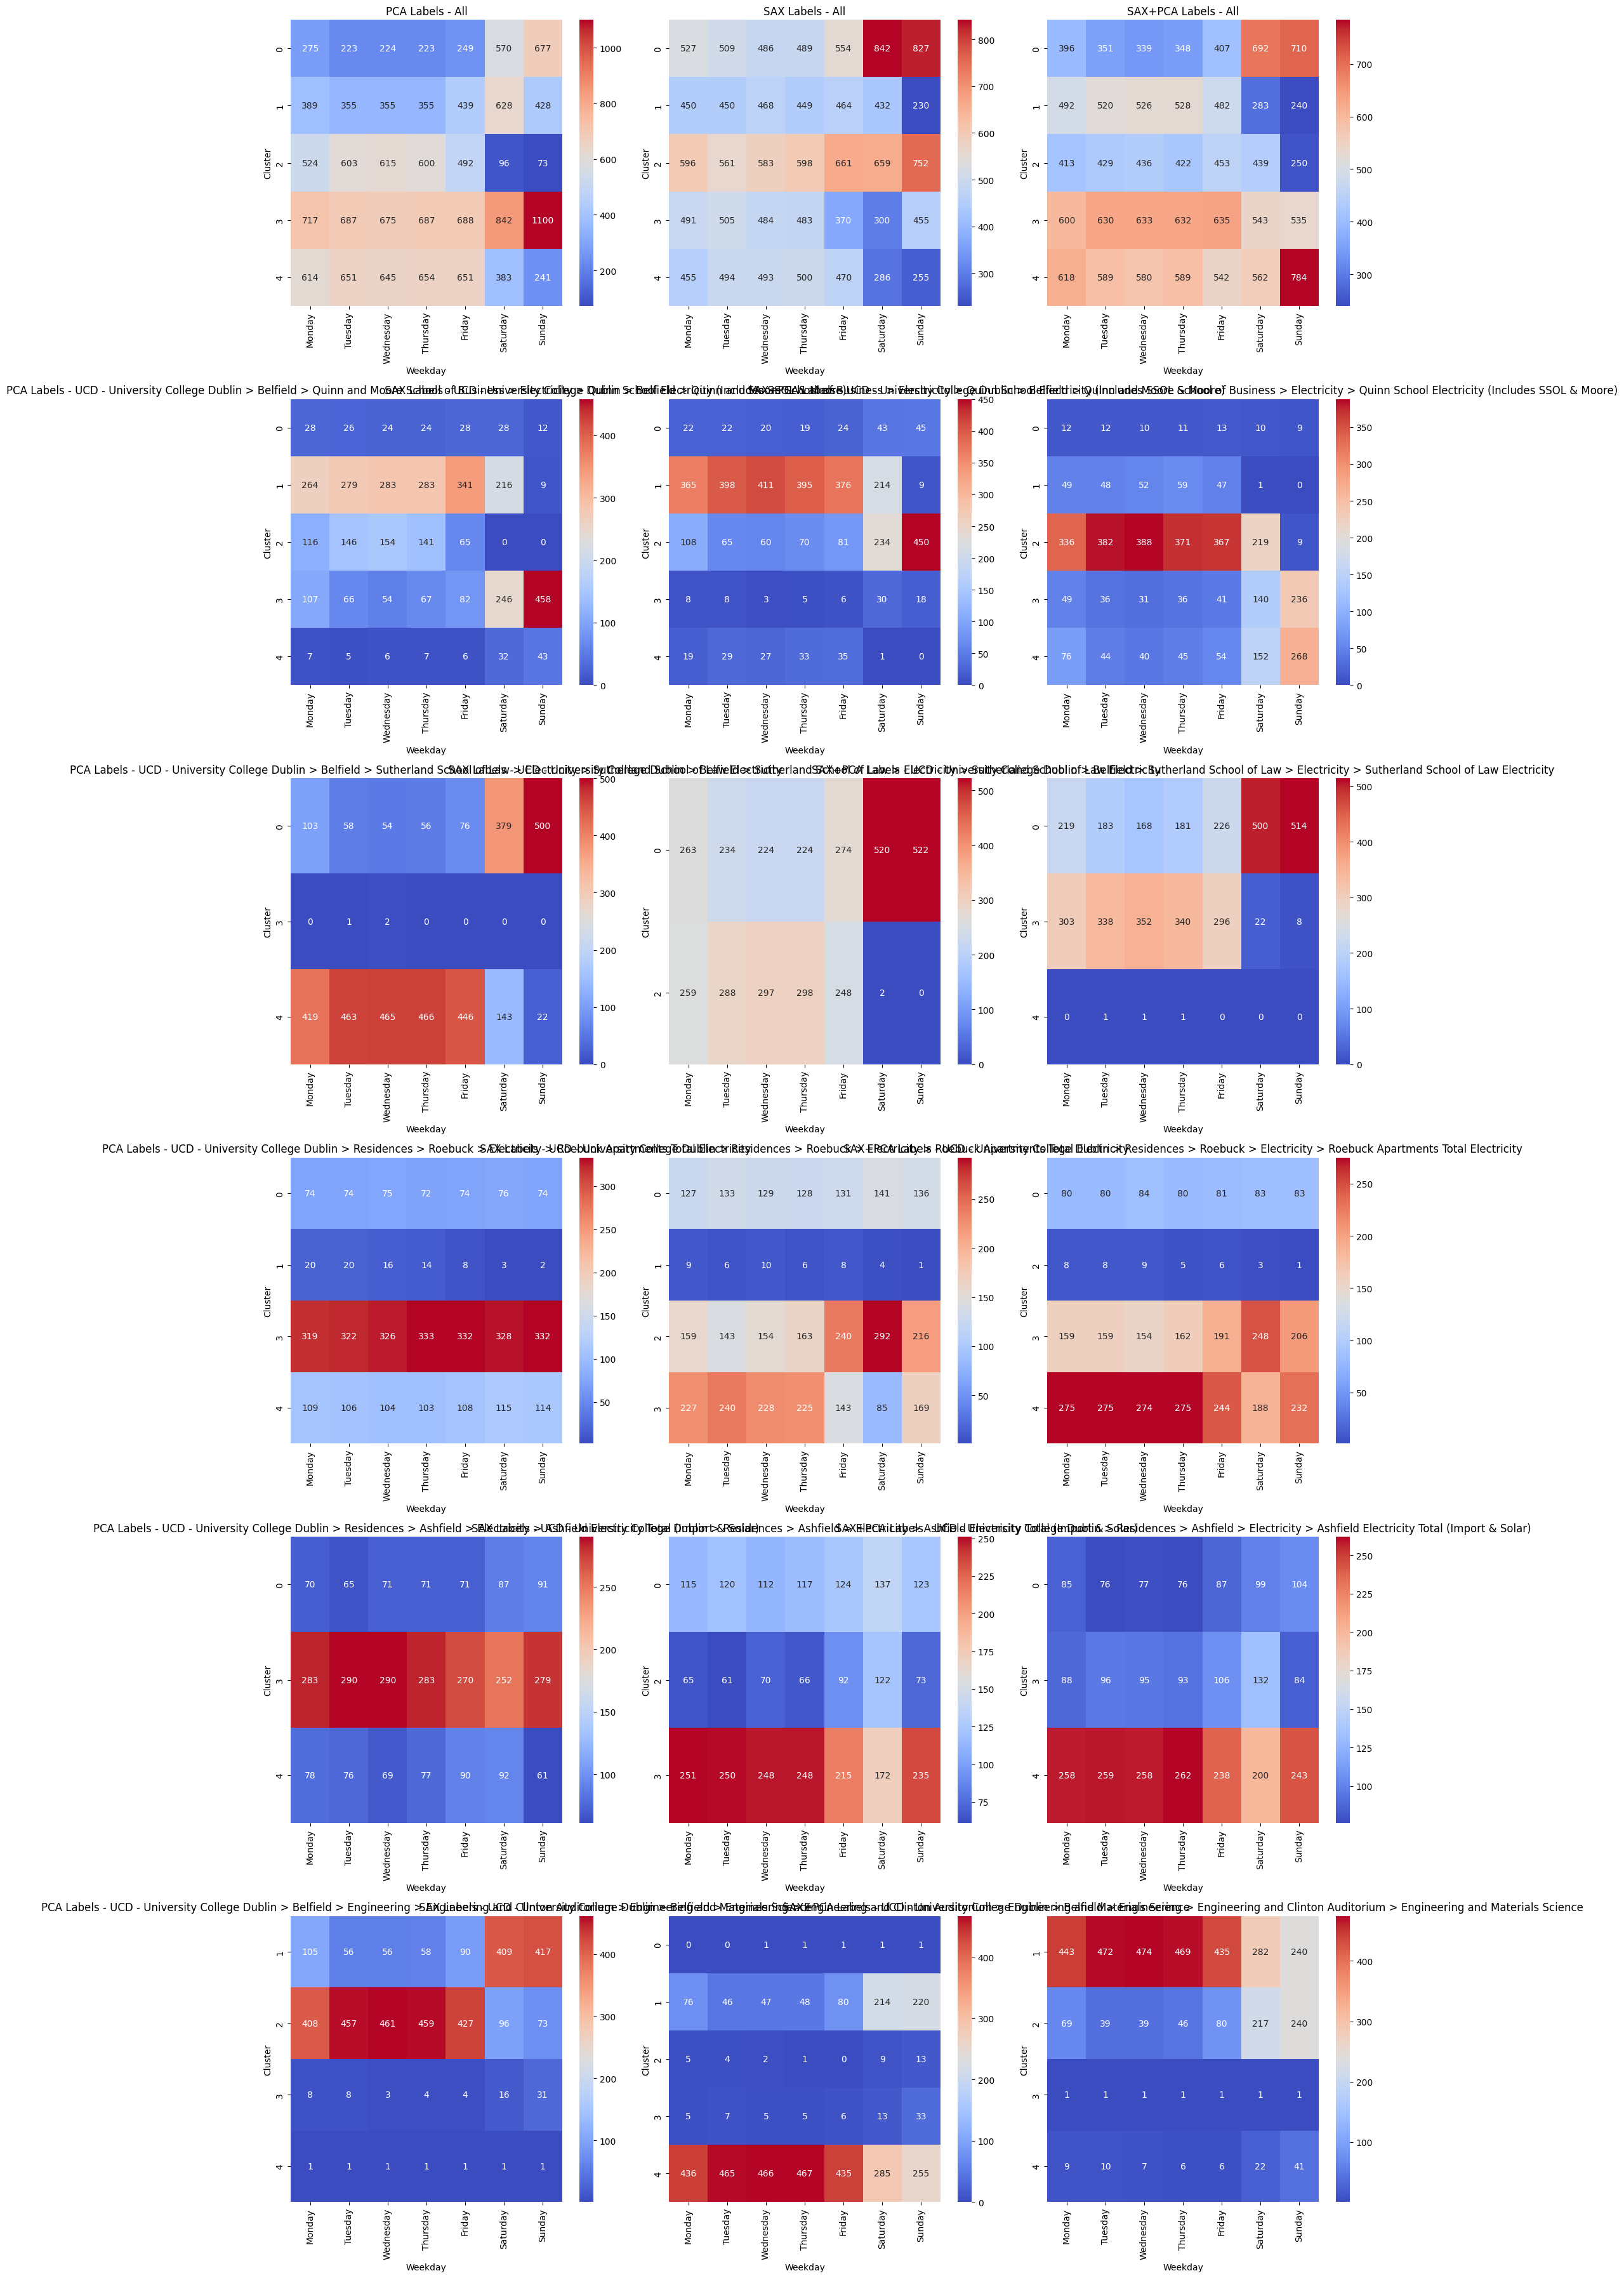

In [44]:
# Calculate number of buildings for subplot layout
n_buildings = len(target_buildings)

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create subplots arranged as 3 columns for each building row
fig, axes = plt.subplots(n_buildings, 3, figsize=(18, 6 * n_buildings))

# Handle case where there's only one building (axes won't be a 2D array)
if n_buildings == 1:
    axes = axes.reshape(1, -1)

# Define the label columns and their titles
label_columns = ['PCA_Labels', 'SAX_Labels', 'SAX+PCA_Labels']
titles = ['PCA Labels', 'SAX Labels', 'SAX+PCA Labels']

for idx, building in enumerate(target_buildings):
    
    # Fix the filter condition - check if building is 'All'
    filter_df = cluster_df if building == 'All' else cluster_df[cluster_df['Building'] == building]

    # Ensure Date is numeric
    filter_df = filter_df.copy()  # Avoid SettingWithCopyWarning
    filter_df['Date'] = pd.to_numeric(filter_df['Date'], errors='coerce')

    # Create heatmaps for each label type
    for col_idx, (label_col, title) in enumerate(zip(label_columns, titles)):
        # Create Weekday-cluster summary for heatmap
        heatmap_df = filter_df.groupby(['Weekday', label_col])['Date'].count().reset_index()

        # Pivot to make Weekday as columns, Clusters as rows
        heatmap_pivot = heatmap_df.pivot(index=label_col, columns='Weekday', values='Date')

        heatmap_pivot = heatmap_pivot.reindex(columns=weekday_order)

        # Fill NaN values with 0 and convert to float
        heatmap_pivot = heatmap_pivot.fillna(0).astype(float)

        # Plot heatmap on the specific subplot
        sns.heatmap(heatmap_pivot, cmap="coolwarm", annot=True, fmt=".0f", ax=axes[idx, col_idx])
        
        # Set title - simplified version
        axes[idx, col_idx].set_title(f"{title} - {building}")
        axes[idx, col_idx].set_xlabel("Weekday")
        axes[idx, col_idx].set_ylabel("Cluster")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [45]:
# Create subplots - one below the other
fig, axes = plt.subplots(len(labels), 1, figsize=(10, 6 * len(labels)))

# Ensure axes is always a list (for single plot case)
if len(labels) == 1:
    axes = [axes]

for idx, label_col in enumerate(labels):
    building_counts = cluster_df.groupby([label_col, 'Building']).size().reset_index(name='Count')

    sns.countplot(data=cluster_df, x=label_col, hue='Building', ax=axes[idx])
    axes[idx].set_title(f"{titles[idx]} - Building Distribution Across Clusters")
    axes[idx].set_xlabel("Cluster")
    axes[idx].set_ylabel("Count")
    axes[idx].legend(title="Building", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

KeyError: 5

Error in callback <function _draw_all_if_interactive at 0x0000017589E49E40> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 1000x10576800 pixels is too large. It must be less than 2^23 in each direction.

ValueError: Image size of 1000x10576800 pixels is too large. It must be less than 2^23 in each direction.

<Figure size 1000x1.05768e+07 with 17628 Axes>

In [51]:
def plot_cluster_distribution_by_weekday(cluster_df, method_name):
    cluster_df = cluster_df.copy()
    
    # Weekday ordering
    weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    cluster_df["Weekday"] = pd.Categorical(cluster_df["Weekday"], categories=weekday_order, ordered=True)
    
    # Count clusters
    weekday_counts = cluster_df.groupby(["Weekday", "SAX_Labels"]).size().reset_index(name="Count")
    weekday_pivot = weekday_counts.pivot(index="Weekday", columns="SAX_Labels", values="Count").fillna(0)
    
    # Custom color map
    custom_colors = ["#87CEEB", "#FFF68F", "#228B22", "#8B0000", "#8B4513"]
    
    # Plot stacked bar chart
    weekday_pivot.plot(kind="bar", stacked=True, figsize=(10,6), color=custom_colors)
    
    plt.title(f"Cluster Distribution by Day of Week ({method_name})")
    plt.xlabel("Day of Week")
    plt.ylabel("Number of Days in Each Cluster")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

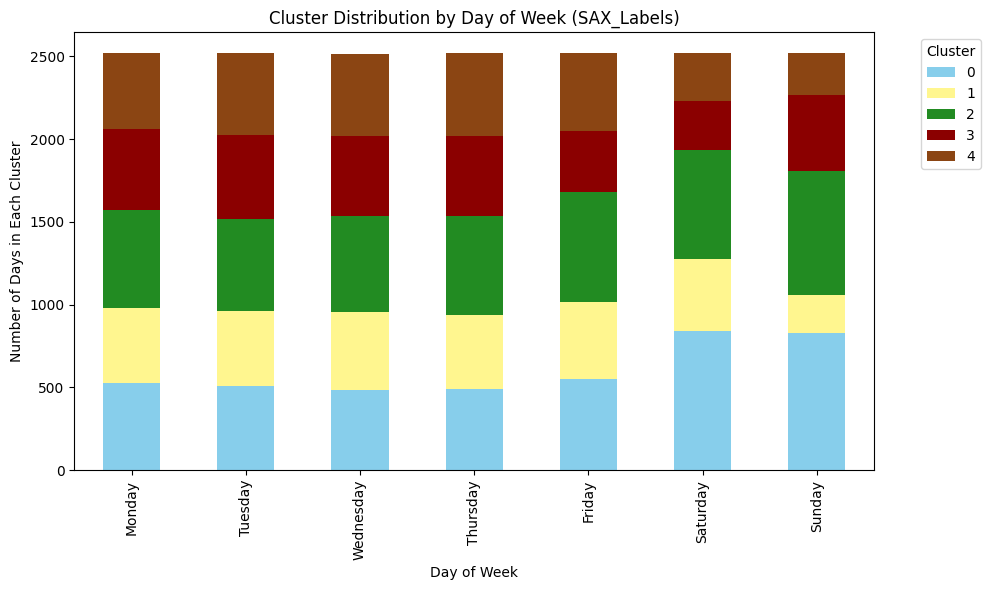

In [52]:
plot_cluster_distribution_by_weekday(cluster_df, "SAX_Labels")

In [53]:
def plot_cluster_profiles(original_ts, reduced_data_dict, cluster_labels_dict, n_samples=2):
    """
    original_ts: ndarray shape (n_series, time_steps) -> e.g., norm_energy
    reduced_data_dict: dict of technique_name -> reduced_data (same n_series rows)
    cluster_labels_dict: dict of technique_name -> cluster_labels (same order as reduced_data)
    n_samples: number of similar/non-similar to show
    """
    
    for method in reduced_data_dict.keys():
        labels = cluster_labels_dict[method]
        technique_data = reduced_data_dict[method]
        
        unique_clusters = np.unique(labels)
        fig, axes = plt.subplots(1, len(unique_clusters), figsize=(5 * len(unique_clusters), 4), sharey=True)
        if len(unique_clusters) == 1:
            axes = [axes]
        
        fig.suptitle(f"{method} Clustering Profiles", fontsize=14)
        
        for ax, cluster_id in zip(axes, unique_clusters):
            cluster_idx = np.where(labels == cluster_id)[0]
            cluster_ts = original_ts[cluster_idx]
            
            # Centroid in time series space
            centroid = cluster_ts.mean(axis=0)
            
            # Distances from centroid
            dists = pairwise_distances(cluster_ts, centroid.reshape(1, -1)).flatten()
            sorted_idx = np.argsort(dists)
            
            similar_idx = cluster_idx[sorted_idx[:n_samples]]
            nonsimilar_idx = cluster_idx[sorted_idx[-n_samples:]]
            
            # Plot similar
            for idx in similar_idx:
                ax.plot(original_ts[idx], color="magenta", alpha=0.6, label="Similar" if "Similar" not in ax.get_legend_handles_labels()[1] else "")
            
            # Plot non-similar
            for idx in nonsimilar_idx:
                ax.plot(original_ts[idx], color="green", alpha=0.6, label="Non-Similar" if "Non-Similar" not in ax.get_legend_handles_labels()[1] else "")
            
            # Plot centroid
            ax.plot(centroid, color="black", linewidth=2, label="Centroid")
            
            ax.set_title(f"Cluster {cluster_id}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Normalized Energy")
            ax.grid(alpha=0.3)
            ax.legend()
        
        plt.tight_layout()
        plt.show()

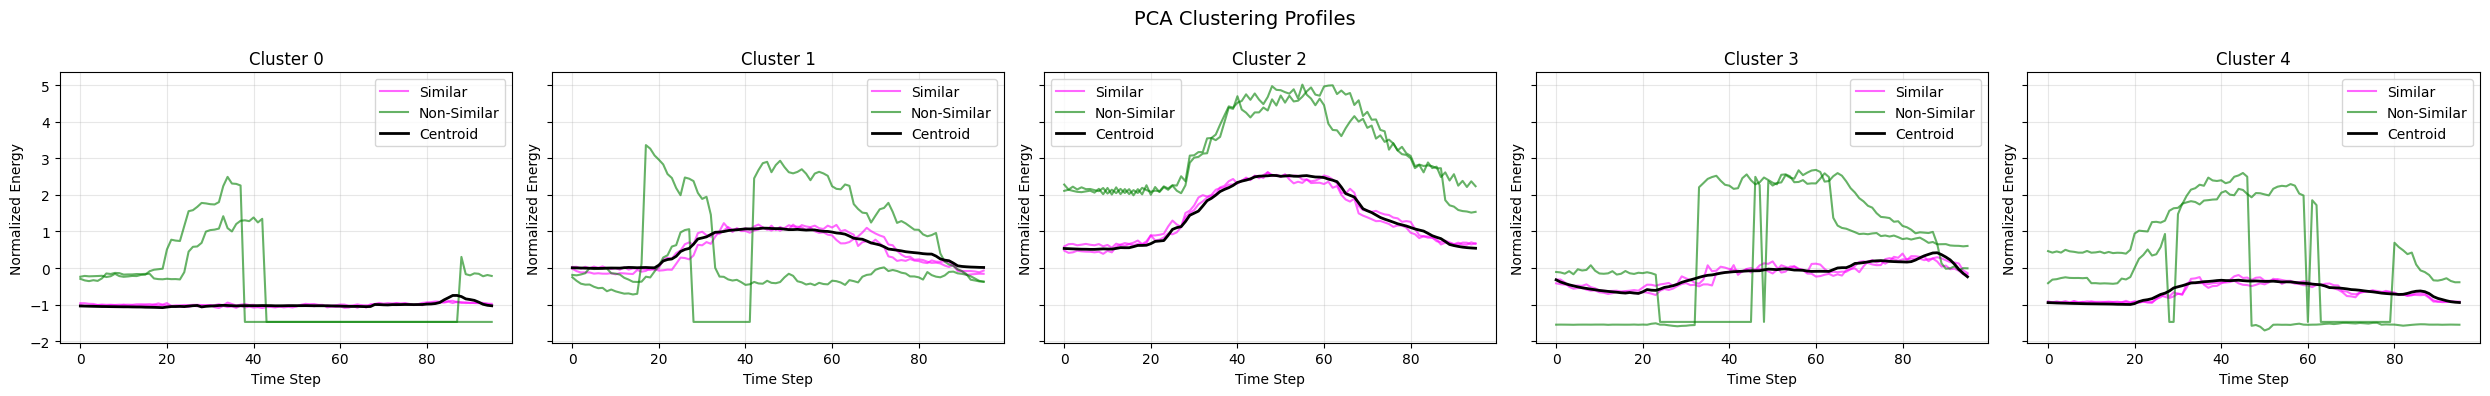

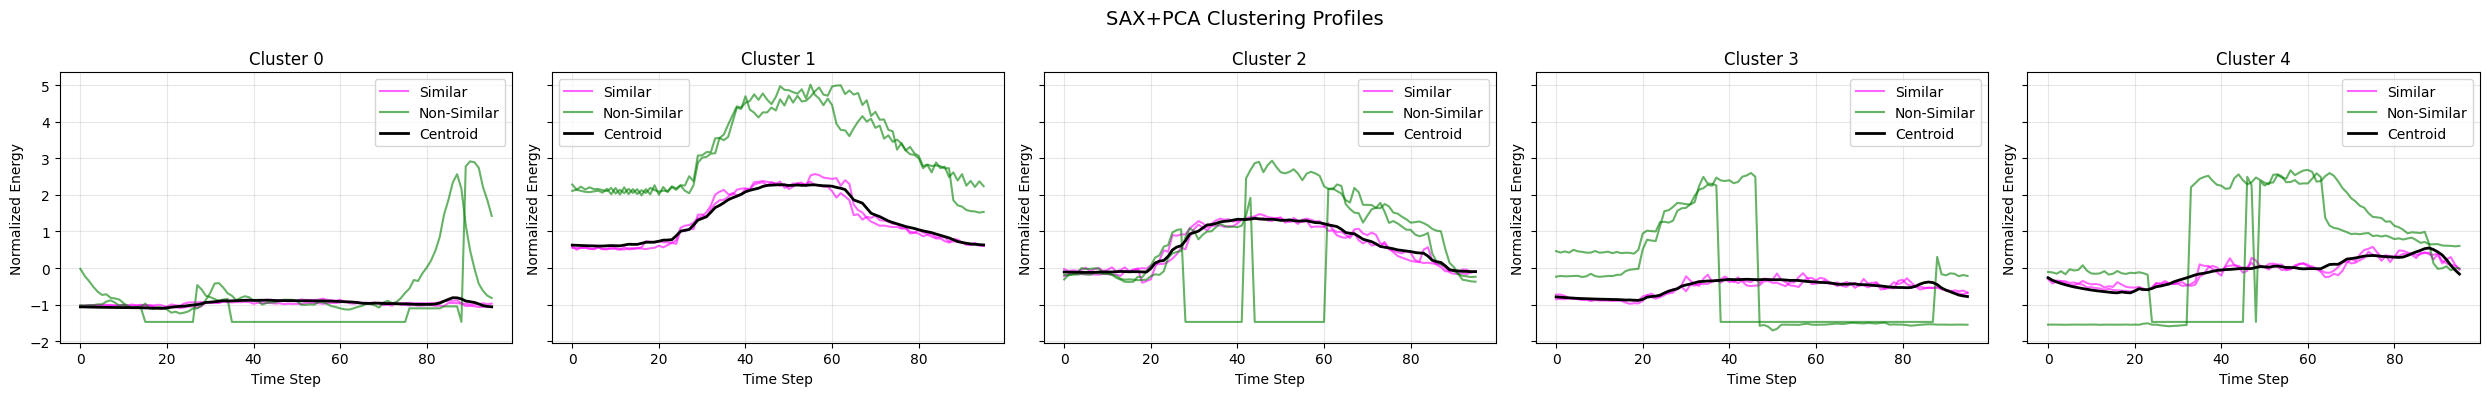

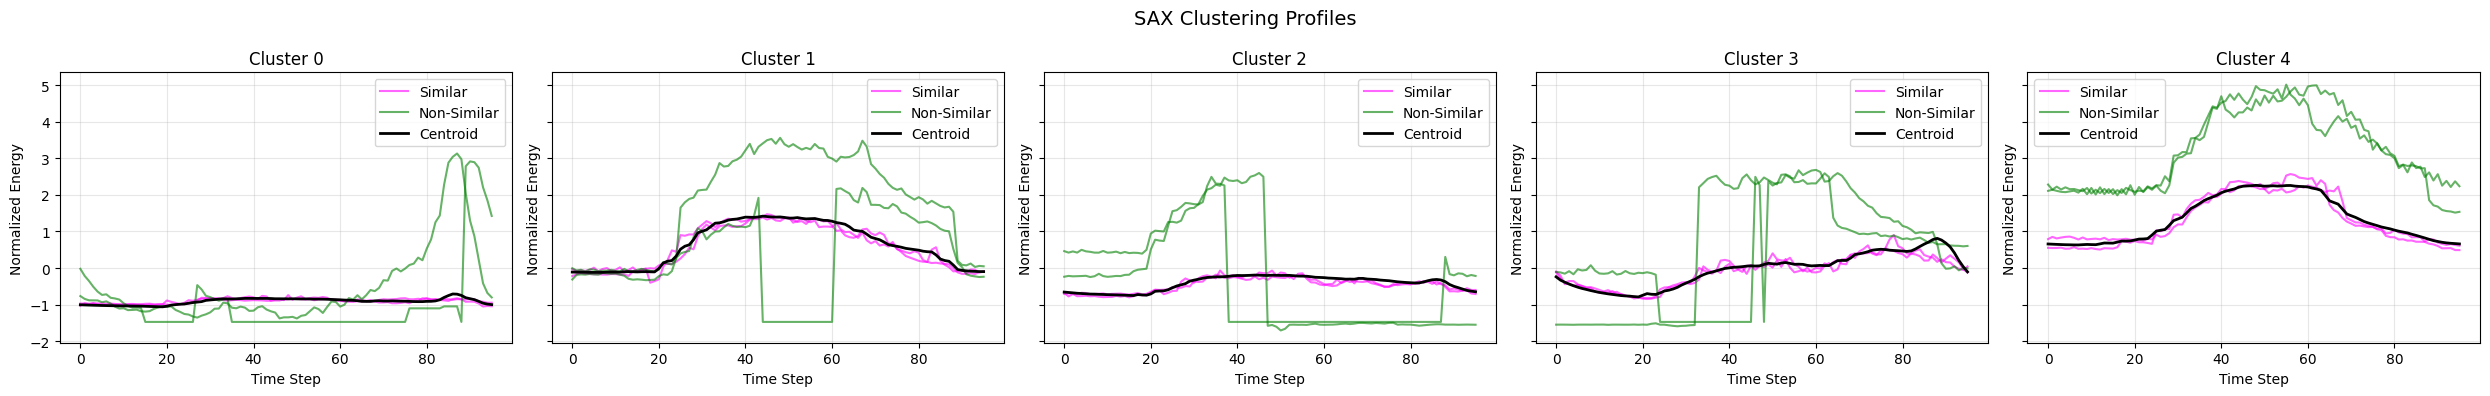

In [54]:
reduced_data_dict = {
    "PCA": pca_result,
    "SAX+PCA": sax_pca,
    "SAX": sax_output
}

cluster_labels_dict = {
    "PCA": KMeans(n_clusters=5, random_state=0).fit_predict(pca_result),
    "SAX+PCA": KMeans(n_clusters=5, random_state=0).fit_predict(sax_pca),
    "SAX": KMeans(n_clusters=5, random_state=0).fit_predict(sax_output)
}

plot_cluster_profiles(norm_energy, reduced_data_dict, cluster_labels_dict)